# Adversarial Latent Autoencoder (ALAE)

The following are notes on the paper [Adversarial Latent Autoencoder](https://arxiv.org/abs/2004.04467) 

with the official implementation available on [github](https://github.com/podgorskiy/ALAE)

## Vanilla GANs

Typically a GAN is composed of a generator network $G$ mapping from a space $Z$ onto a data space $X$, and a discriminator network $D$ mapping from $X$ onto $\mathbb{R}$.

The $Z$ space is characterised by a **known distribution** $p(z$). By sampling fro $p(z)$, the generator $G$ produces data representing a *synthetic* distribution $q(x)$. given training data $\mathbb{D}$ drawn from a *real* distribution $p_{\mathbb{D}}(x)$, a GAN network aims at learning $G$ so that $q(x)$ is as close to $p_{\mathbb{D}}(x)$ as possible.


The GAN problem entails finding the minimax with repsect ot he pair, ($G,D$) of the value function defined as:

$$
V(G, D) = E_{p_{\mathbb{D}}(x)} [f(D(x))] + E_{p(z)} [f(-D(G(z))]
$$

where $E[.]$ donotes expectation, and $f : \mathbb{R} \rightarrow \mathbb{R}$ is a concave function.

## ALAEs

The original GAN paradigm is changed by decomposing the generator $G$ and the discriminator $D$ into two networks:

$$
G = \mathbb{G} \circ F, \text{ and } D = \mathbb{D} \circ E,
$$

where $\mathbb{G} \circ F : z \rightarrow x$ is defined by 
$(\mathbb{G} \circ F)(z) = \mathbb{G}(F(z))$, and $\mathbb{D} \circ E : x \rightarrow z$, is defined by $(\mathbb{D} \circ E)(x) = \mathbb{D}(E(x))$

It is also assumed that the *latent spaces* at the interface between $F$ and $\mathbb{G}$, and between $E$ and $\mathbb{D}$ are the same  and are defined by $w$ (Figure 1).

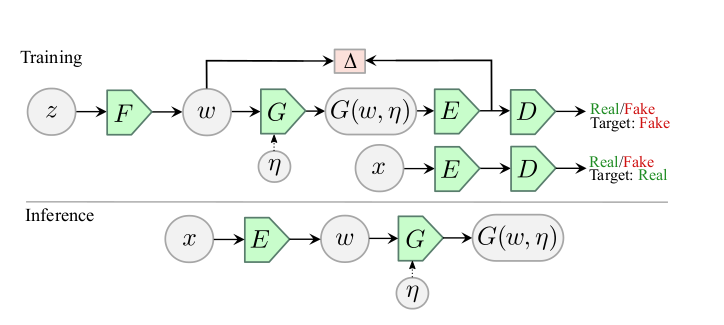
<center><strong>Fig. 1:</strong> Architecture of an Adversarial Latent Autoencoder.</center>
<br>

An optional noise term $\eta$ can be added as dependancy of $\mathbb{G}$, deriving from a fixed known distribution $p_{\eta}(\eta)$ - $\mathbb{G}(w, \eta)$.


There is an additional goals which requires:

$$
q_F(w) = q_E(w)
$$

The pairs of networks ($\mathbb{G}, E$),  can be interpreted as a *generator-encoder* network that autoencodes the *latent space* $W$.

If we indicate with $\Delta (p||q)$ a measure of discrpenacy between the two distributions $p$ and $q$, we propose to achieve that goal via regularizing the GAN loss by alternating the following two optimizations:

$$
min_{F, \mathbb{G}}max_{E, \mathbb{D}} V(\mathbb{G} \circ F, \mathbb{D} \circ E) \\
min_{E,G}\Delta(F || E \circ \mathbb{G} \circ F)
$$

where the left and right arguments of $\Delta$ indicate the discributions generated by the networks mapping $p(z)$, which correspond to $q_{F}(w)$ and $q_E(w)$, respectively.

The reciprocity condition is generally achieved two ways, either $x = G(E(x))$ or equvialenty $w = E(G(w))$. It can be achieved by choosing the divergence to be the expected coding reconstruction error, as follows:

$$
min_{E,G}\Delta(F || E \circ \mathbb{G} \circ F) = 
E_{p(z)}[|| F(z) - E \circ \mathbb{G} \circ F(z) ||_2^2]
$$

Imposing reciprocity in the latent space gives the significant advantage that simple $l_2,l_1$ or other norms can be used effectively, where commonly they are inappropriate for the data space (pixel space).


# Implementation

A non-saturating loss is used which in practice sets $f(.)$ to be a SoftPlus function [[1](http://proceedings.mlr.press/v15/glorot11a/glorot11a.pdf)], which is a smooth version of the rectifier activation function, defined as $f(t) = softplus(t) = log(1 + exp(t))$. In addition, the following gradient regularisation technique is used:

- [Double Backpropagation](http://yann.lecun.com/exdb/publis/pdf/drucker-lecun-91.pdf) - it explicity pushes the input gradients to zero [[2](https://arxiv.org/pdf/1906.06637.pdf)], [[3](https://arxiv.org/abs/1801.04406)] [[4](https://arxiv.org/abs/1711.09404)] [[5](https://arxiv.org/abs/1705.09367)]. 
This is accomplished with a zero-centered $L_2$ norm. Specifically, it acts only on **real data**, and is defined as:

$$
\dfrac{\lambda}{2}E_{p_{Data}(x)}[||\nabla \mathbb{D} \circ E(x)||^2]
$$

where the gradient is taken with respect to the parameters $\theta_E$ and $\theta_{\mathbb{D}}$ of the networks $E$ and $\mathbb{D}$ respectively. This is refered to as $R_1$.

In order to optimize the adversarial and reciprocity losses, three alternativing updates are used:


- <span style="font-family: serif; font-weight:bold;">Step I.</span> -  Update the discriminator (i.e.  networks $E$ and $\mathbb{D}$)
- <span style="font-family: serif; font-weight:bold;">Step II.</span> - Update the generator (i.e. networks $F$ and $\mathbb{G}$)
- <span style="font-family: serif; font-weight:bold;">Step III.</span> - Update the latent space autoencoder (i.e. networks $\mathbb{G}$ and $E$).

The procedure is as follows:

```java
θ_F, θ_G, θ_E, θ_D ⟵ init() // Initialize network parameters
β1 = 0.0
β2 = 0.99
α = Learning rate
while not converged do

    // Step I. Update E and D
    x ⟵ Random mini-batch from dataset     
    z ⟵ Samples from prior N(0, I)     
    L_adv_E_D ⟵ softplus(D◦E◦G◦F(z)) + softplus(-D◦E(x)) + R1
    θ_E, θ_D ⟵ ADAM(∇(θ_D, θ_E), L_adv_E_D,
                     [θ_D, θ_E], α, β1, β2)
    
    // Step II. Update F and G
    z ⟵ sample from prior N(0,I)
    L_adv_F_G ⟵ softplus(-D◦E◦G◦F(z))
    θ_F, θ_G ⟵ ADAM(∇(θ_F, θ_G), L_adv_F_G,
                     [θ_F, θ_G], α, β1, β2)
    
    // Step II. Update E and G
    z ⟵ Samples from prior N(0,I)
    L_recip ⟵ L2(F(z), E◦G◦F(z))
    θ_E, θ_G ⟵ ADAM(∇(θ_E, θ_G), L_error,
                     [θ_E, θ_G], α, β1, β2)
end while
```

The Adam optimizer uses $\beta_1 = 0.0$ and $\beta_2 = 0.99$, coupled with the learning rate equalization technique [[6](https://arxiv.org/abs/1710.10196)]



<hr>

### Notes:

- Implementation of equilized learning rate and a few other nice things in tensorflow - <a style="text-decoration: none;" href="https://github.com/preritj/progressive_growing_of_GANs/blob/master/net.py">`github`</a>
- Orthogonal Weight Initialisation using [Keras](https://keras.io/api/layers/initializers/) - often used but not in this network


# Implementation 

In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np

from tensorflow.keras.layers import Dense, Input, LeakyReLU, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import normal
from tensorflow.keras.activations import softplus as f
from tensorflow.keras.optimizers import Adam

from keras.utils import Progbar

import matplotlib.pyplot as plt

/home/simon/anaconda3/envs/DL/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/simon/anaconda3/envs/DL/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/simon/anaconda3/envs/DL/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/simon/anaconda3/envs/DL/lib/python3.6/site-packages/ten

In [2]:
class DenseEQ(Dense):
    """
    Standard dense layer but includes learning rate equilization
    at runtime as per Karras et al. 2017.

    Inherits Dense layer and overides the call method.
    """
    def __init__(self, **kwargs):
        if 'kernel_initializer' in kwargs:
            raise Exception("Cannot override kernel_initializer")
        super().__init__(kernel_initializer=normal, **kwargs)

    def build(self, input_shape):
        super().build(input_shape)
        # The number of inputs
        n = np.product([int(val) for val in input_shape[1:]])
        # He initialisation constant
        self.c = np.sqrt(2/n)

    def call(self, inputs):
        output = K.dot(inputs, self.kernel*self.c) # scale kernel
        if self.use_bias:
            output = K.bias_add(output, self.bias, data_format='channels_last')
        if self.activation is not None:
            output = self.activation(output)
        return output

The following example is the MNIST model from the paper. It is implemented as a MLP, with 28x28x1 flattened to a 784D vector. It consists of three layers MLP for networks $F$ and $\mathbb{D}$, with a latent dimension of size $50$. The networks $E$ and $\mathbb{G}$ have two hidden layers with 1024 units. LeakyRelu is used for all activations.

In [3]:
X_DIM = np.product((28, 28, 1))
Z_DIM = 50
H_DIM = 1024
BATCH_SIZE = 128

# Data

In [4]:
from tensorflow.keras.datasets import mnist

In [5]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [6]:
# Reshape to (60K, 784) and (60K, 1)
x_train = x_train.reshape((x_train.shape[0], X_DIM)) / 255.
y_train = y_train.reshape((y_train.shape[0], 1))
# Reshape to (10K, 784) and (10K, 1)
x_test = x_test.reshape((x_test.shape[0], X_DIM)) / 255.
y_test = y_test.reshape((y_test.shape[0], 1))

In [7]:
# Shuffle
indices = np.arange(60000)
np.random.shuffle(indices)

In [8]:
K.clear_session()

### F Network

In [9]:
F_input = Input(shape=(Z_DIM,), name="F_input")
x = DenseEQ(units=Z_DIM, name="F_Dense_1")(F_input)
x = LeakyReLU(0.2, name="F_Act_1")(x)
x = DenseEQ(units=Z_DIM, name="F_Dense_2")(x)
x = LeakyReLU(0.2, name="F_Act_2")(x)
x = DenseEQ(units=Z_DIM, name="F_Dense_3")(x)
F_output = LeakyReLU(0.2, name="F_Act_3")(x)
F = Model(inputs=[F_input], outputs=[F_output], name="F")

In [10]:
#F.summary()

### D Network

In [11]:
D_input = Input(shape=(Z_DIM,), name="D_input")
x = DenseEQ(units=Z_DIM, name="D_Dense_1")(D_input)
x = LeakyReLU(0.2, name="D_Act_1")(x)
x = DenseEQ(units=Z_DIM, name="D_Dense_2")(x)
x = LeakyReLU(0.2, name="D_Act_2")(x)
D_output = DenseEQ(units=1, name="D_predict")(x)
D = Model(inputs=[D_input], outputs=[D_output], name="D")

In [12]:
#D.summary()

### G Network

In [13]:
G_input = Input(shape=(Z_DIM,), name="G_input")
x = DenseEQ(units=H_DIM, name="G_Dense_1")(G_input)
x = LeakyReLU(0.2, name="G_Act_1")(x)
x = DenseEQ(units=H_DIM, name="G_Dense_2")(x)
x = LeakyReLU(0.2, name="G_Act_2")(x)
# output - image space (which activation?)
x = DenseEQ(units=X_DIM, name="G_Dense_3")(x)
G_output = LeakyReLU(0.2, name="G_Act_3")(x)
G = Model(inputs=[G_input], outputs=[G_output], name="G")

In [14]:
#G.summary()

### E Network

In [15]:
E_input = Input(shape=(X_DIM,), name="E_input")
x = DenseEQ(units=H_DIM, name="E_Dense_1")(E_input)
x = LeakyReLU(0.2, name="E_Act_1")(x)
x = DenseEQ(units=H_DIM, name="E_Dense_2")(x)
x = LeakyReLU(0.2, name="E_Act_2")(x)
x = DenseEQ(units=Z_DIM, name="E_Dense_3")(x)
E_output = LeakyReLU(0.2, name="E_Act_3")(x)
E = Model(inputs=[E_input], outputs=[E_output], name="E")

In [16]:
#E.summary()

With the sub-networks defined, we can put them together to create the Discriminator,Generator and Reciprocal networks, as well as the inference network.

$$
G = \mathbb{G} \circ F \\
D = \mathbb{D} \circ E \\
R = E \circ \mathbb{G} \circ F \\
I = E \circ G
$$

### Discriminator

In [17]:
discriminator_in = Input(shape=(X_DIM,))
discriminator_out = D(E(discriminator_in))
discriminator = Model(inputs=[discriminator_in],
                     outputs=[discriminator_out],
                     name="discriminator"
                    )

### Generator

In [18]:
generator_in = Input(shape=(Z_DIM,))
generator_out = G(F(generator_in))
generator = Model(inputs=[generator_in],
                     outputs=[generator_out],
                     name="generator"
                    )

### Reciprocal

In [19]:
reciprocal_in = Input(shape=(Z_DIM,)) # W is input
reciprocal_out = E(G(reciprocal_in))
reciprocal = Model(inputs=[reciprocal_in],
                     outputs=[reciprocal_out],
                     name="reciprocal"
                    )

### Inference

In [20]:
inference_in = Input(shape=(X_DIM,), name="inference_input")
inference_out = G(E(inference_in))
inference = Model(inputs=[inference_in],
                     outputs=[inference_out],
                     name="inference"
                    )

This experiment will extend the standard ALAE by including a reconstruction regularisation on the $x$ space, using the inference network. This will be MSE to push it in the right direction, but not constrain it like a VAE.

# Losses

In [21]:
def l2(x_true, x_pred):
    """
    L2 for the reciprocal loss in latent space 
    """
    return K.mean((x_true - x_pred)**2)


def discriminator_logistic_non_saturating(result, input_tensor, real, γ=10.0): 
    """
    Discriminator loss including R1 gradient penality on the input, where f = softplus.
    
    Note: Uses double back-propagation in r1 sub-function
    
    :param - result - discriminator result
    :param - input_tensor - input tensor to calculate r1 loss
    :param - real - bool indicating real or fake output
    :param - γ - the gamma value for r1
    """
    
    def r1(loss, input_tensor):
        """
        Calculates the R1 gradient penalty on the input tensor.
        """
        grads = K.gradients(loss, input_tensor)[0]
        loss = K.sum(grads**2)
        return loss

    if real:
        loss = f(-result)
        if γ > 0:
            loss += (γ/2)*r1(loss, input_tensor)
    else:
        loss = f(result)
  
    return K.mean(loss)


def generator_logistic_non_saturating(result):
    """
    generator loss, where f = softplus
    """
    loss = f(-result)
    return K.mean(loss)

In [22]:
# Place-Holders
discriminator_fake_in = Input(shape=(X_DIM,), name="discriminator_fake_input")
discriminator_real_in = Input(shape=(X_DIM,), name="discriminator_real_input")
generator_fake_in = Input(shape=(Z_DIM,), name="generator_fake_input")

# Operations
d_result_fake = discriminator(discriminator_fake_in) 
d_result_real = discriminator(discriminator_real_in)
g_result_fake = discriminator(generator(generator_fake_in))

In [23]:
L_adv_E_D = discriminator_logistic_non_saturating(result=d_result_fake,
                                                  input_tensor=None,
                                                  real=False,
                                                  γ=None) + \
            discriminator_logistic_non_saturating(result=d_result_real,
                                                  input_tensor=discriminator_real_in,
                                                  real=True,
                                                  γ=0.1)

L_adv_F_G = generator_logistic_non_saturating(g_result_fake)

L_recip = l2(reciprocal_in, reciprocal_out)

# Optimizers

In [24]:
Adam = tf.train.AdamOptimizer

In [25]:
# Parameters
θ_F = F.trainable_weights
θ_G = G.trainable_weights
θ_E = E.trainable_weights
θ_D = D.trainable_weights

# Hyper-parameters
α = 0.002
β1 = 0.0
β2 = 0.99
ε = K.epsilon()

# Optimizers
D_optimizer = Adam(α, β1, β2, ε)
G_optimizer = Adam(α, β1, β2, ε)
R_optimizer = Adam(α, β1, β2, ε)
I_optimizer = Adam(α, β1, β2, ε)

# Gradients
discriminator_grads = D_optimizer.compute_gradients(loss=L_adv_E_D, var_list=θ_E + θ_D)
generator_grads     = G_optimizer.compute_gradients(loss=L_adv_F_G, var_list=θ_F + θ_G)
reciprocal_grads    = R_optimizer.compute_gradients(loss=L_recip, var_list=θ_G + θ_E)

# Operations
ADAM_d = D_optimizer.apply_gradients(discriminator_grads)
ADAM_g = G_optimizer.apply_gradients(generator_grads)
ADAM_r = R_optimizer.apply_gradients(reciprocal_grads)

# Training

In [26]:
# test z
z_test = np.random.normal(0, 1, (12, Z_DIM))
# test x
x_test = x_train[0:12]

# x_test as image stack 
x_reals = [img.reshape(28,28) for img in x_test]
x_reals = np.hstack(x_reals)

In [27]:
def get_batch(i):
    return x_train[indices[i*BATCH_SIZE:i*BATCH_SIZE + BATCH_SIZE]]

In [28]:
sess = K.get_session()

# Initialize network parameters
init = tf.global_variables_initializer()
init.run(session=sess)

Epoch: 1
442/468 [===========================>..] - ETA: 0s - Loss_D: 1.3863 - Loss_G: 0.6931 - Loss_R: 1.3368e-06

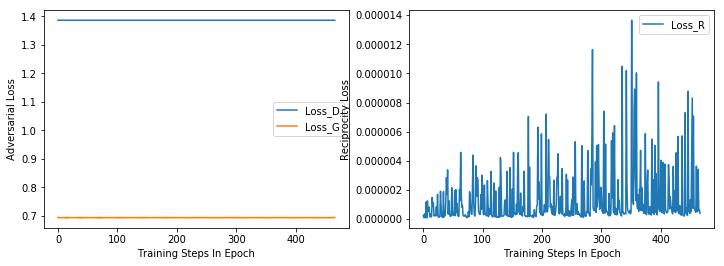

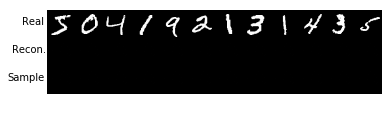

---------------------------------------------------------
Epoch: 2
441/468 [===========================>..] - ETA: 0s - Loss_D: 1.3863 - Loss_G: 0.6931 - Loss_R: 1.8685e-06

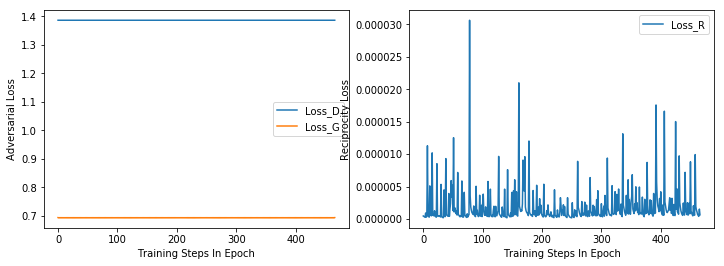

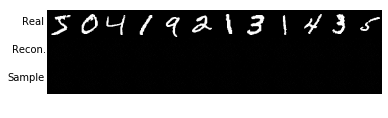

---------------------------------------------------------
Epoch: 3
444/468 [===========================>..] - ETA: 0s - Loss_D: 1.2096 - Loss_G: 0.8135 - Loss_R: 0.0041  

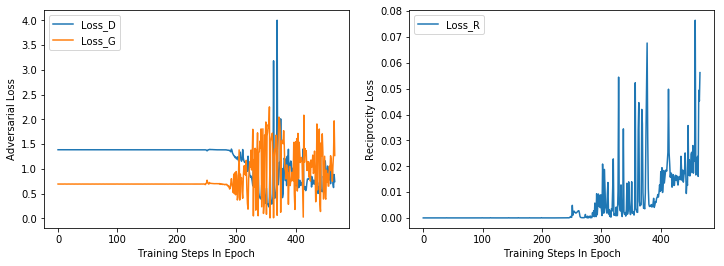

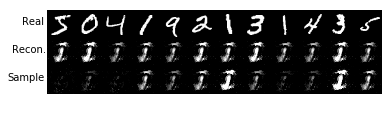

---------------------------------------------------------
Epoch: 4
443/468 [===========================>..] - ETA: 0s - Loss_D: 0.7867 - Loss_G: 0.9871 - Loss_R: 0.0089 

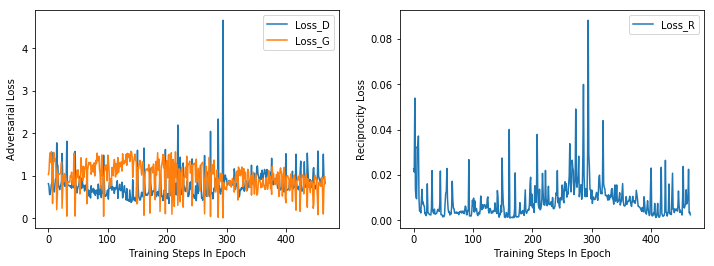

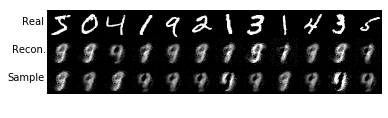

---------------------------------------------------------
Epoch: 5
449/468 [===========================>..] - ETA: 0s - Loss_D: 1.0576 - Loss_G: 0.7416 - Loss_R: 0.0097 

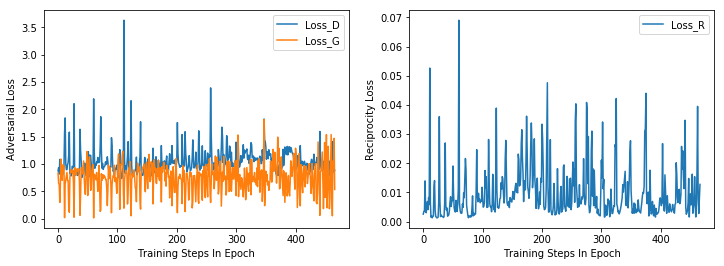

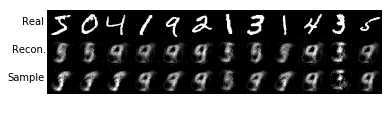

---------------------------------------------------------
Epoch: 6
440/468 [===========================>..] - ETA: 0s - Loss_D: 0.9883 - Loss_G: 0.9544 - Loss_R: 0.0135 

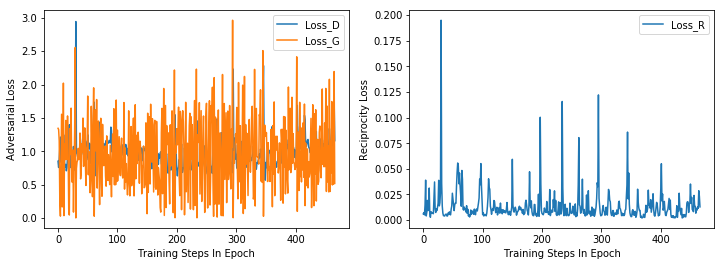

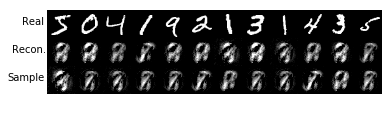

---------------------------------------------------------
Epoch: 7
443/468 [===========================>..] - ETA: 0s - Loss_D: 1.1102 - Loss_G: 0.9661 - Loss_R: 0.0123 

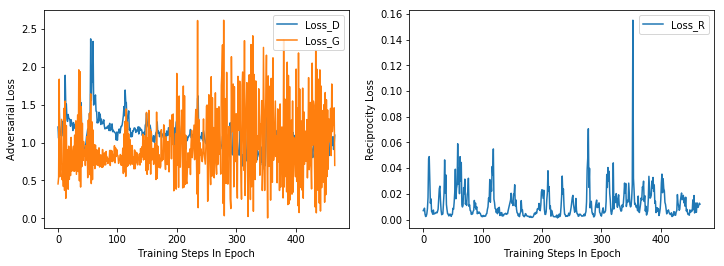

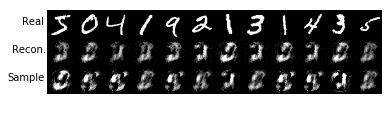

---------------------------------------------------------
Epoch: 8
439/468 [===========================>..] - ETA: 0s - Loss_D: 0.9938 - Loss_G: 1.1018 - Loss_R: 0.0093 

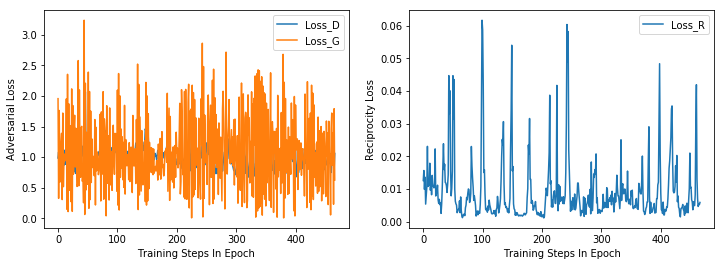

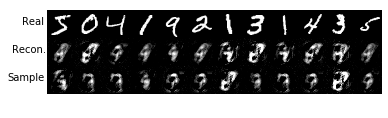

---------------------------------------------------------
Epoch: 9
439/468 [===========================>..] - ETA: 0s - Loss_D: 1.1306 - Loss_G: 0.9835 - Loss_R: 0.0090 

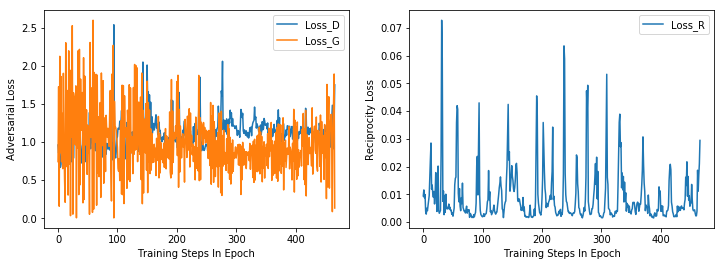

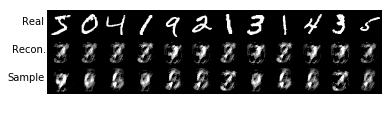

---------------------------------------------------------
Epoch: 10
444/468 [===========================>..] - ETA: 0s - Loss_D: 1.1339 - Loss_G: 0.9261 - Loss_R: 0.0070 

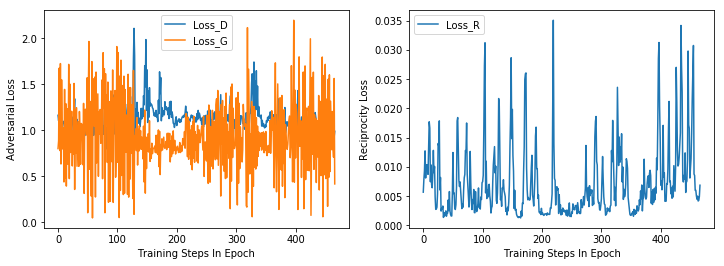

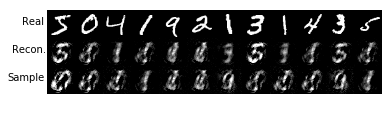

---------------------------------------------------------
Epoch: 11
442/468 [===========================>..] - ETA: 0s - Loss_D: 0.9765 - Loss_G: 1.0538 - Loss_R: 0.0076 

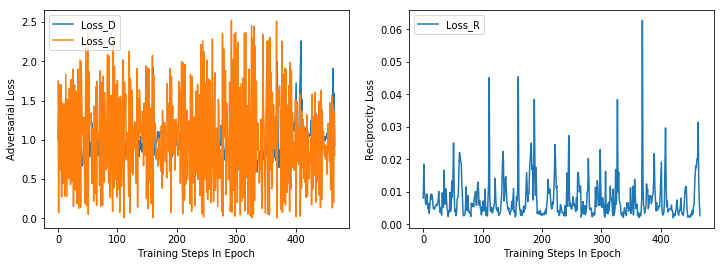

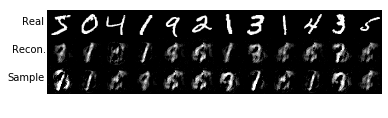

---------------------------------------------------------
Epoch: 12
441/468 [===========================>..] - ETA: 0s - Loss_D: 1.0446 - Loss_G: 0.9785 - Loss_R: 0.0085 

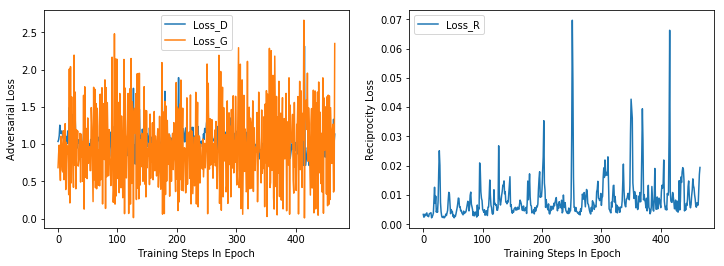

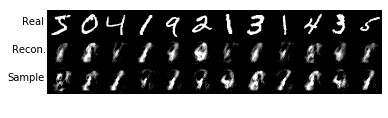

---------------------------------------------------------
Epoch: 13
441/468 [===========================>..] - ETA: 0s - Loss_D: 1.1308 - Loss_G: 0.8493 - Loss_R: 0.0082 

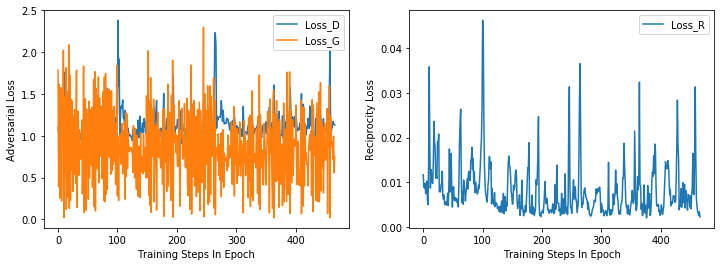

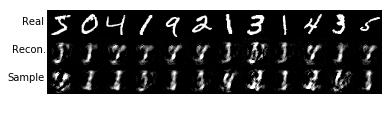

---------------------------------------------------------
Epoch: 14
440/468 [===========================>..] - ETA: 0s - Loss_D: 1.0551 - Loss_G: 0.8866 - Loss_R: 0.0081 

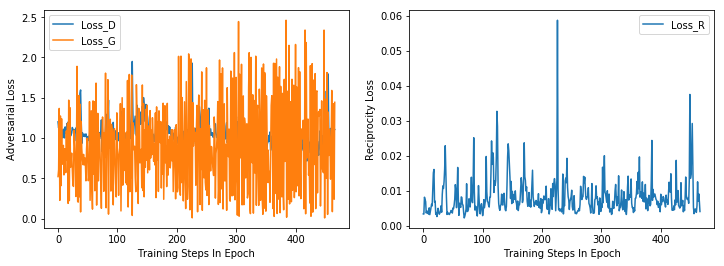

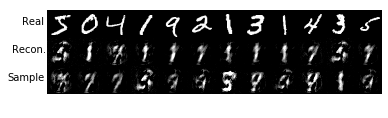

---------------------------------------------------------
Epoch: 15
439/468 [===========================>..] - ETA: 0s - Loss_D: 1.1225 - Loss_G: 0.8788 - Loss_R: 0.0092 

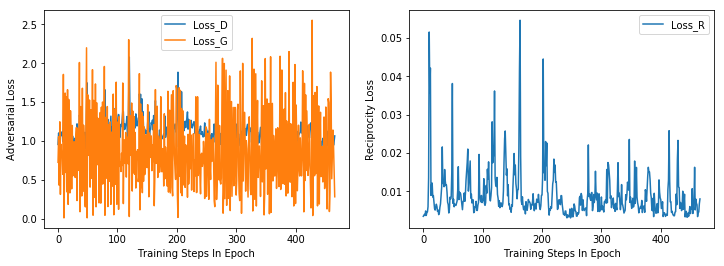

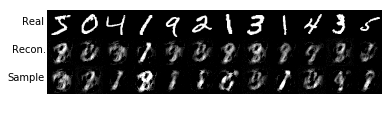

---------------------------------------------------------
Epoch: 16
439/468 [===========================>..] - ETA: 0s - Loss_D: 1.0575 - Loss_G: 0.9083 - Loss_R: 0.0076

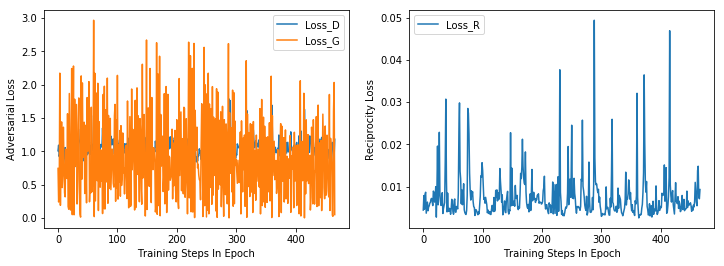

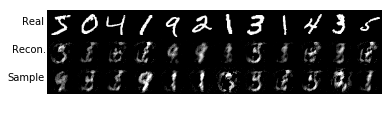

---------------------------------------------------------
Epoch: 17
441/468 [===========================>..] - ETA: 0s - Loss_D: 1.0584 - Loss_G: 0.9655 - Loss_R: 0.0085 

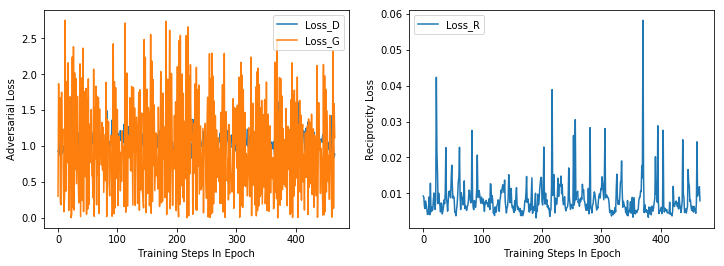

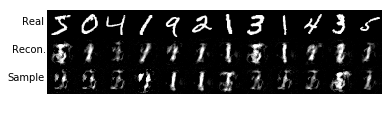

---------------------------------------------------------
Epoch: 18
442/468 [===========================>..] - ETA: 0s - Loss_D: 1.0487 - Loss_G: 1.0163 - Loss_R: 0.0077 

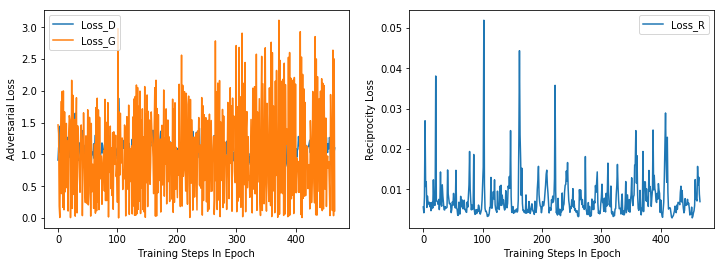

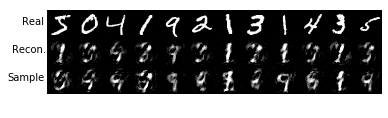

---------------------------------------------------------
Epoch: 19
443/468 [===========================>..] - ETA: 0s - Loss_D: 1.2319 - Loss_G: 0.8769 - Loss_R: 0.0074 

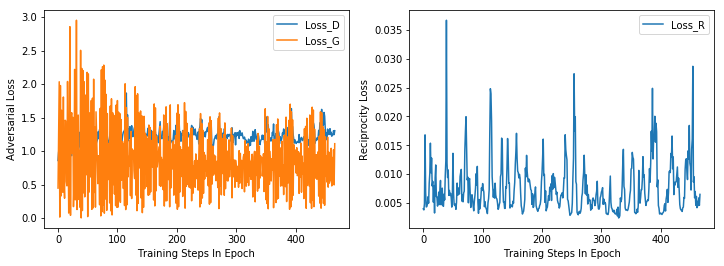

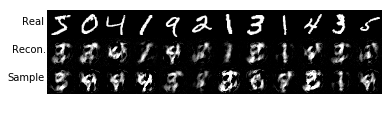

---------------------------------------------------------
Epoch: 20
444/468 [===========================>..] - ETA: 0s - Loss_D: 1.2592 - Loss_G: 0.7699 - Loss_R: 0.0094 

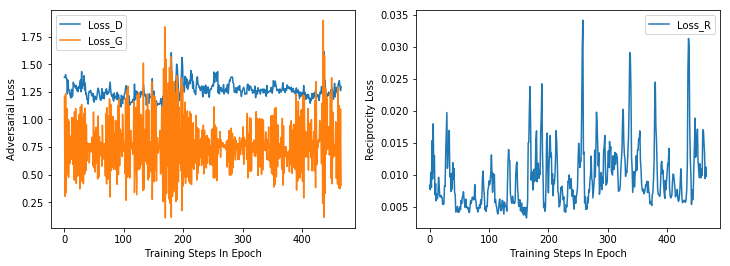

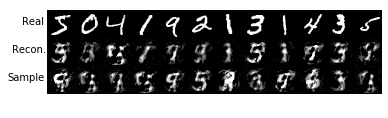

---------------------------------------------------------
Epoch: 21
440/468 [===========================>..] - ETA: 0s - Loss_D: 1.2565 - Loss_G: 0.7834 - Loss_R: 0.0122 

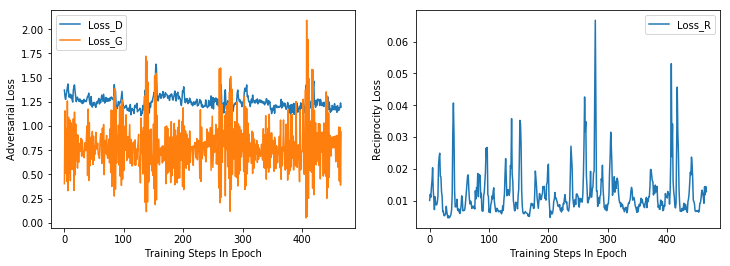

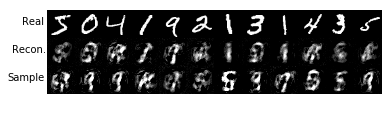

---------------------------------------------------------
Epoch: 22
441/468 [===========================>..] - ETA: 0s - Loss_D: 1.2165 - Loss_G: 0.8145 - Loss_R: 0.0128 

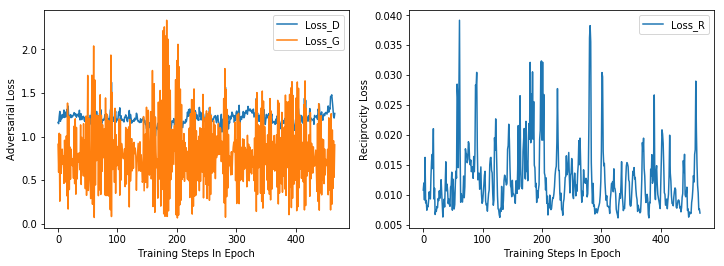

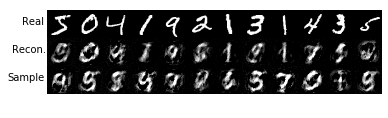

---------------------------------------------------------
Epoch: 23
441/468 [===========================>..] - ETA: 0s - Loss_D: 1.2479 - Loss_G: 0.7445 - Loss_R: 0.0108 

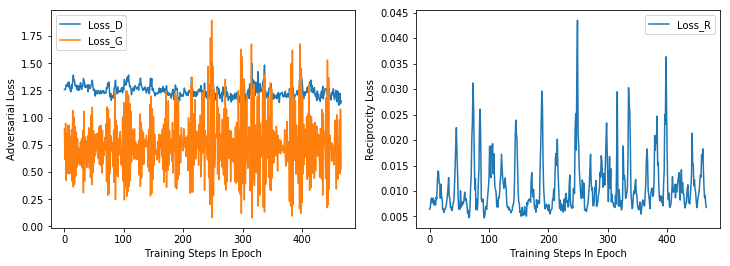

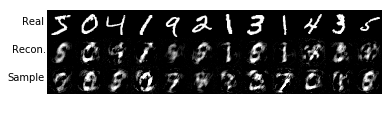

---------------------------------------------------------
Epoch: 24
439/468 [===========================>..] - ETA: 0s - Loss_D: 1.2235 - Loss_G: 0.7811 - Loss_R: 0.0135 

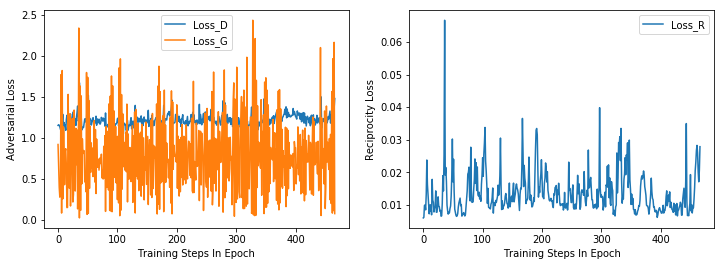

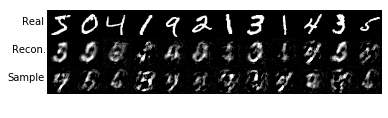

---------------------------------------------------------
Epoch: 25
443/468 [===========================>..] - ETA: 0s - Loss_D: 1.2376 - Loss_G: 0.8086 - Loss_R: 0.0127 

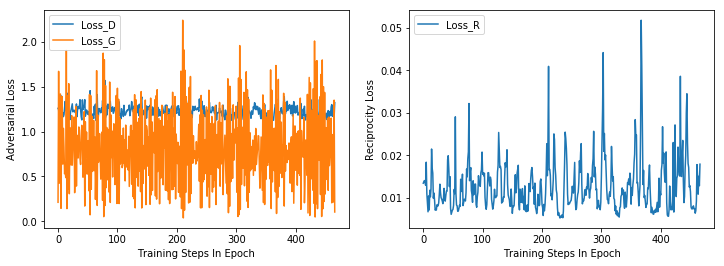

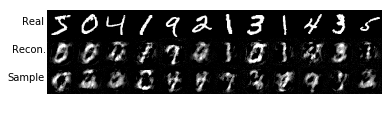

---------------------------------------------------------
Epoch: 26
439/468 [===========================>..] - ETA: 0s - Loss_D: 1.2716 - Loss_G: 0.7325 - Loss_R: 0.0131

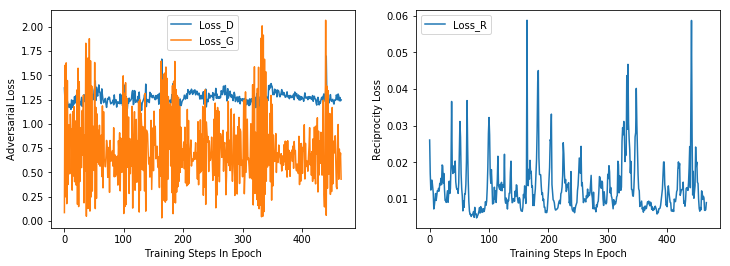

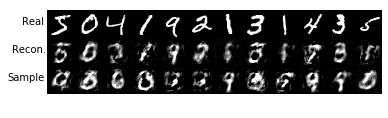

---------------------------------------------------------
Epoch: 27
439/468 [===========================>..] - ETA: 0s - Loss_D: 1.2918 - Loss_G: 0.6925 - Loss_R: 0.0182 

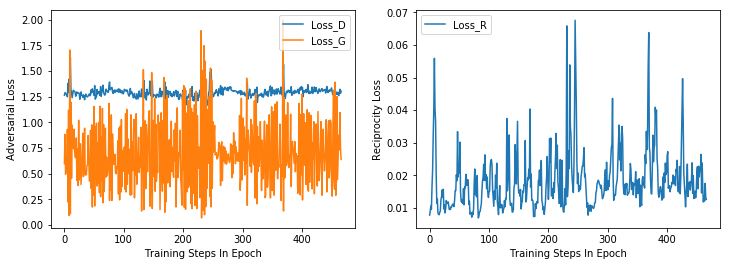

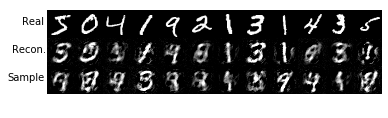

---------------------------------------------------------
Epoch: 28
439/468 [===========================>..] - ETA: 0s - Loss_D: 1.2970 - Loss_G: 0.6991 - Loss_R: 0.0238 

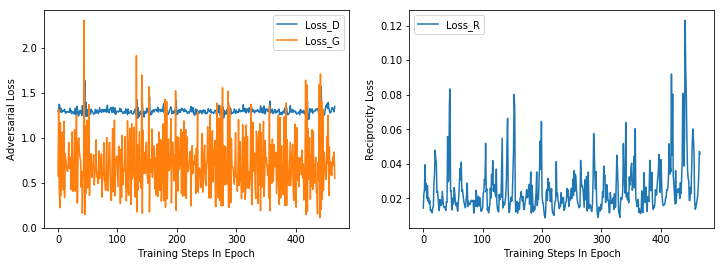

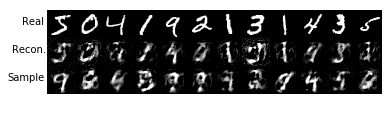

---------------------------------------------------------
Epoch: 29
442/468 [===========================>..] - ETA: 0s - Loss_D: 1.3184 - Loss_G: 0.6734 - Loss_R: 0.0300 

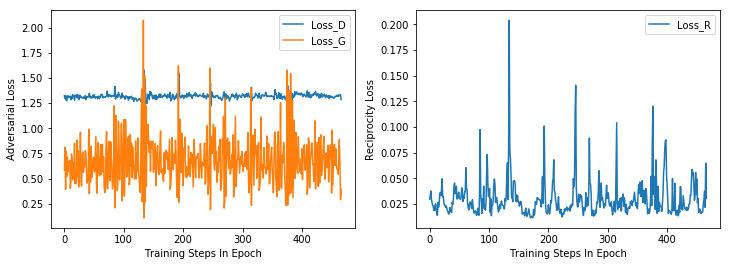

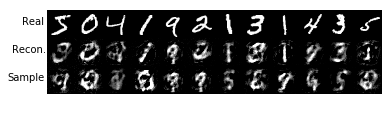

---------------------------------------------------------
Epoch: 30
442/468 [===========================>..] - ETA: 0s - Loss_D: 1.3261 - Loss_G: 0.6795 - Loss_R: 0.0389 

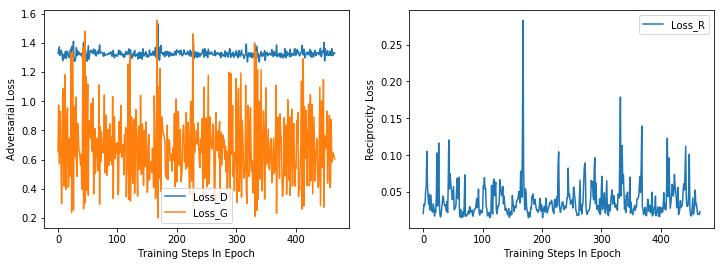

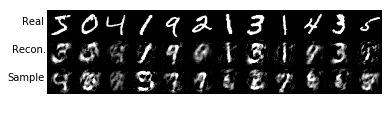

---------------------------------------------------------
Epoch: 31
443/468 [===========================>..] - ETA: 0s - Loss_D: 1.3499 - Loss_G: 0.6691 - Loss_R: 0.0363 

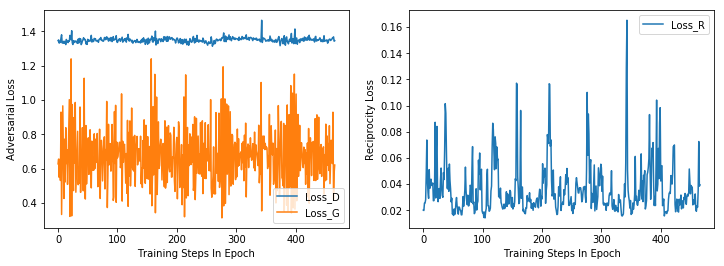

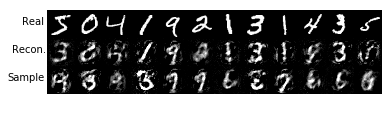

---------------------------------------------------------
Epoch: 32
441/468 [===========================>..] - ETA: 0s - Loss_D: 1.3565 - Loss_G: 0.6847 - Loss_R: 0.0390 

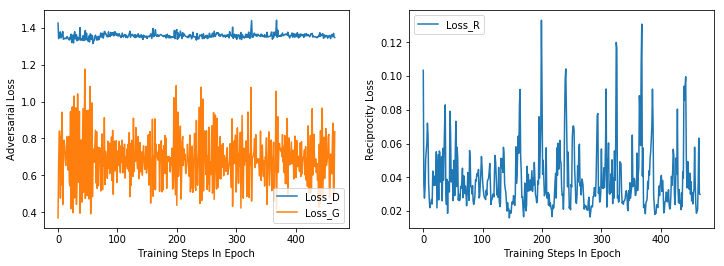

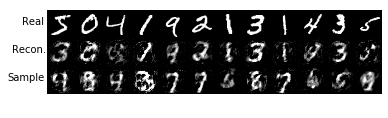

---------------------------------------------------------
Epoch: 33
445/468 [===========================>..] - ETA: 0s - Loss_D: 1.3635 - Loss_G: 0.6960 - Loss_R: 0.0404 

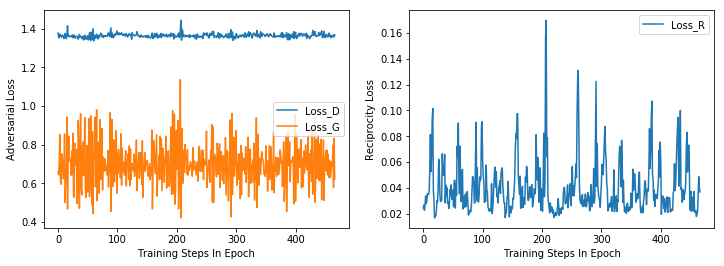

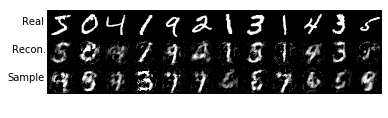

---------------------------------------------------------
Epoch: 34
447/468 [===========================>..] - ETA: 0s - Loss_D: 1.3678 - Loss_G: 0.6964 - Loss_R: 0.0431 

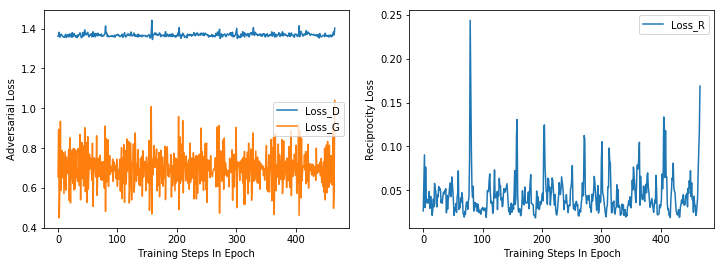

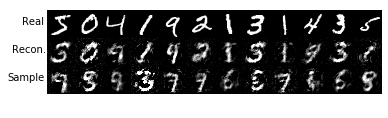

---------------------------------------------------------
Epoch: 35
442/468 [===========================>..] - ETA: 0s - Loss_D: 1.3715 - Loss_G: 0.6964 - Loss_R: 0.0476 

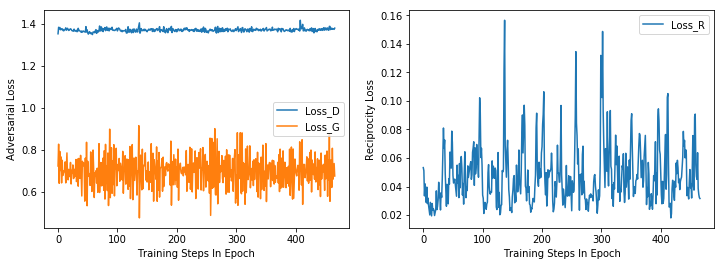

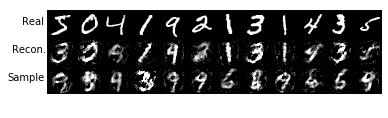

---------------------------------------------------------
Epoch: 36
441/468 [===========================>..] - ETA: 0s - Loss_D: 1.3737 - Loss_G: 0.6983 - Loss_R: 0.0536 

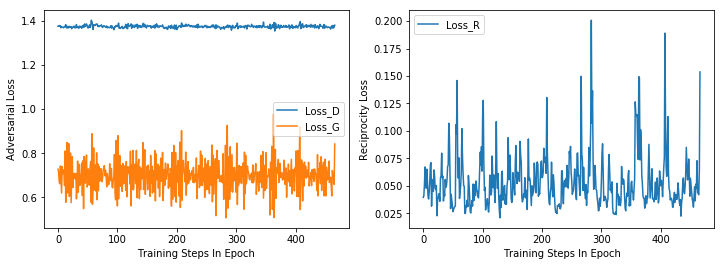

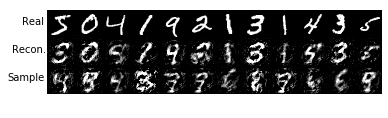

---------------------------------------------------------
Epoch: 37
442/468 [===========================>..] - ETA: 0s - Loss_D: 1.3738 - Loss_G: 0.7007 - Loss_R: 0.0561 

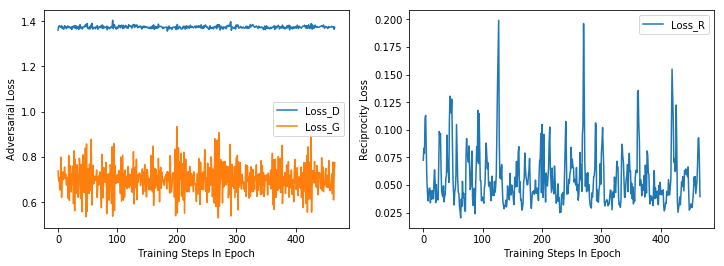

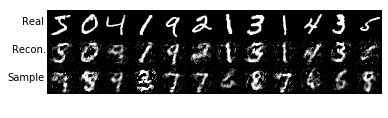

---------------------------------------------------------
Epoch: 38
443/468 [===========================>..] - ETA: 0s - Loss_D: 1.3748 - Loss_G: 0.6999 - Loss_R: 0.0571 

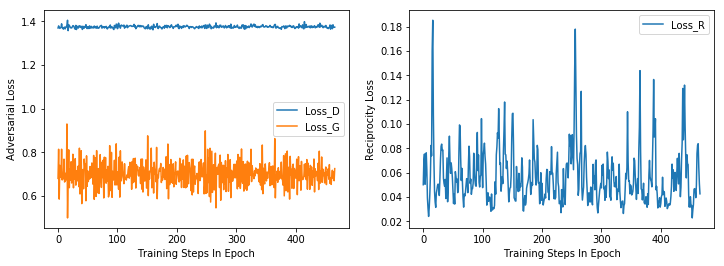

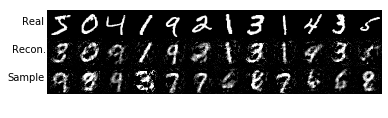

---------------------------------------------------------
Epoch: 39
441/468 [===========================>..] - ETA: 0s - Loss_D: 1.3757 - Loss_G: 0.6988 - Loss_R: 0.0562

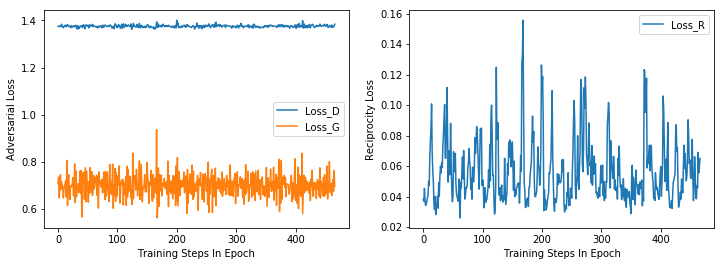

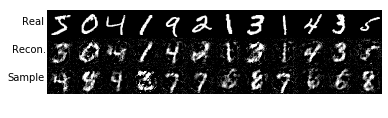

---------------------------------------------------------
Epoch: 40
439/468 [===========================>..] - ETA: 0s - Loss_D: 1.3761 - Loss_G: 0.6968 - Loss_R: 0.0545 

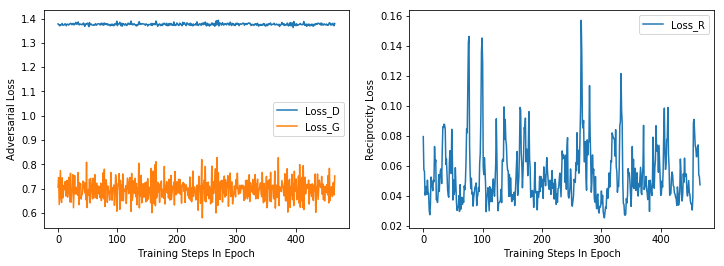

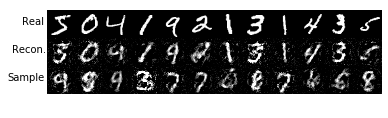

---------------------------------------------------------
Epoch: 41
449/468 [===========================>..] - ETA: 0s - Loss_D: 1.3754 - Loss_G: 0.6958 - Loss_R: 0.0540 

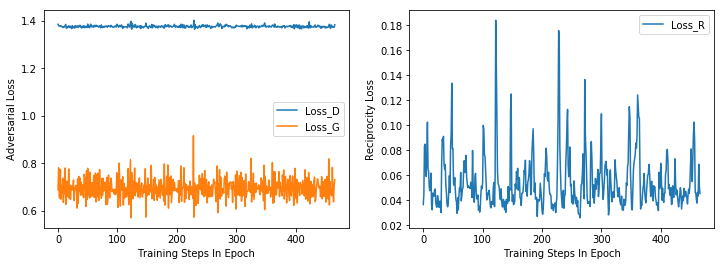

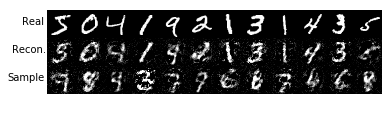

---------------------------------------------------------
Epoch: 42
443/468 [===========================>..] - ETA: 0s - Loss_D: 1.3757 - Loss_G: 0.6966 - Loss_R: 0.0543 

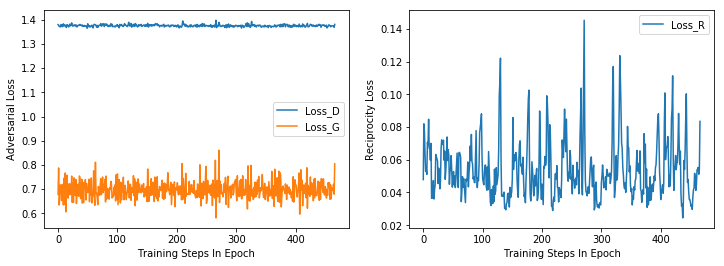

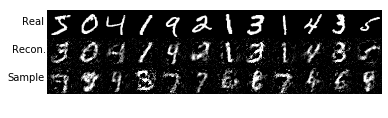

---------------------------------------------------------
Epoch: 43
443/468 [===========================>..] - ETA: 0s - Loss_D: 1.3759 - Loss_G: 0.6990 - Loss_R: 0.0553 

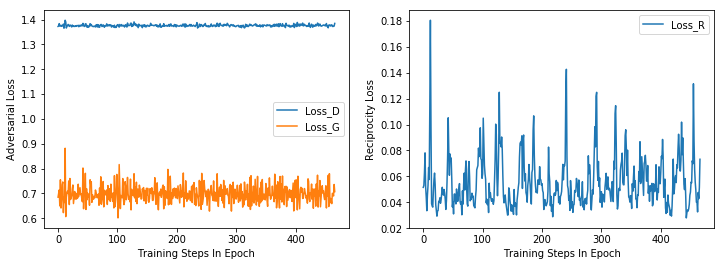

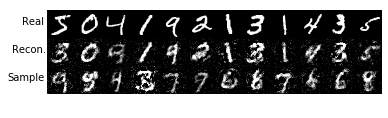

---------------------------------------------------------
Epoch: 44
442/468 [===========================>..] - ETA: 0s - Loss_D: 1.3766 - Loss_G: 0.6996 - Loss_R: 0.0594 

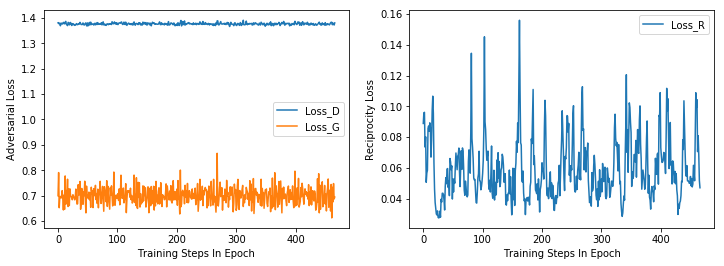

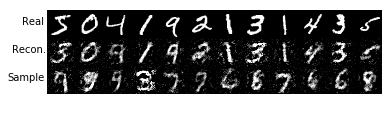

---------------------------------------------------------
Epoch: 45
441/468 [===========================>..] - ETA: 0s - Loss_D: 1.3764 - Loss_G: 0.6995 - Loss_R: 0.0640 

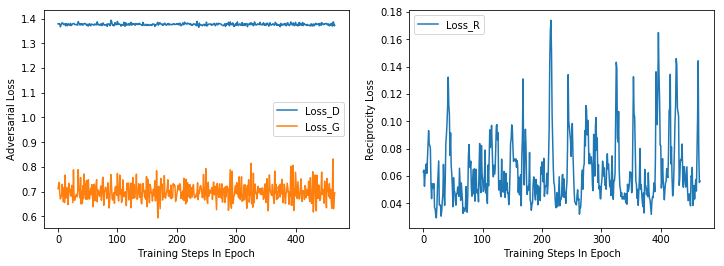

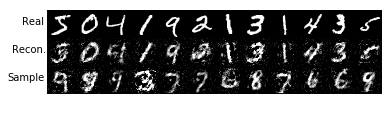

---------------------------------------------------------
Epoch: 46
439/468 [===========================>..] - ETA: 0s - Loss_D: 1.3766 - Loss_G: 0.6992 - Loss_R: 0.0667 

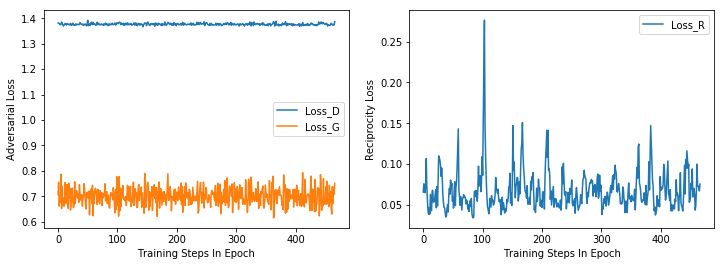

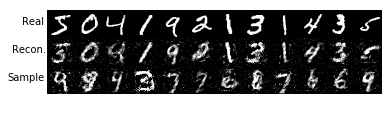

---------------------------------------------------------
Epoch: 47
434/468 [==========================>...] - ETA: 0s - Loss_D: 1.3767 - Loss_G: 0.6977 - Loss_R: 0.0768

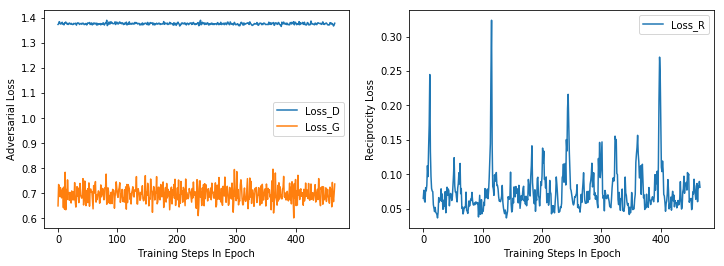

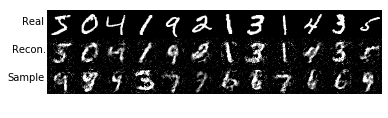

---------------------------------------------------------
Epoch: 48
439/468 [===========================>..] - ETA: 0s - Loss_D: 1.3771 - Loss_G: 0.6984 - Loss_R: 0.0855 

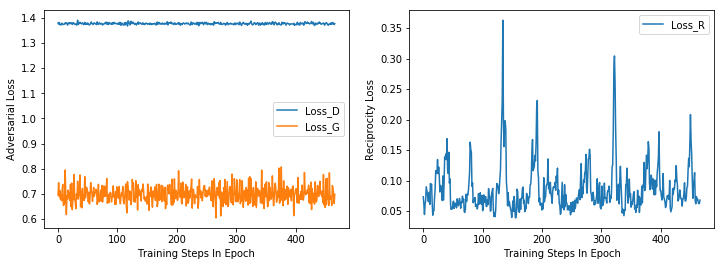

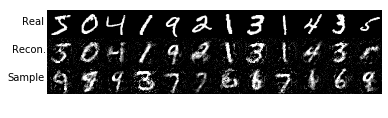

---------------------------------------------------------
Epoch: 49
443/468 [===========================>..] - ETA: 0s - Loss_D: 1.3770 - Loss_G: 0.6995 - Loss_R: 0.0990 

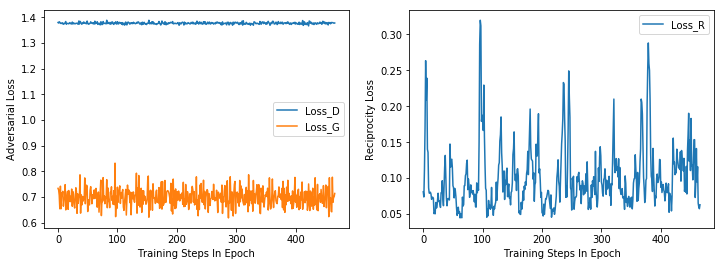

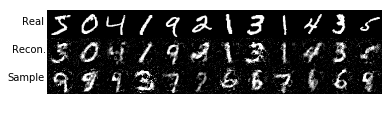

---------------------------------------------------------
Epoch: 50
441/468 [===========================>..] - ETA: 0s - Loss_D: 1.3772 - Loss_G: 0.6986 - Loss_R: 0.1161 

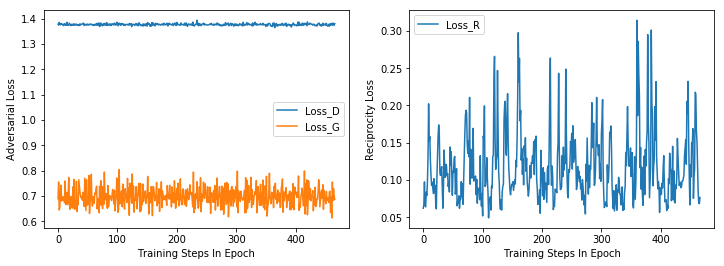

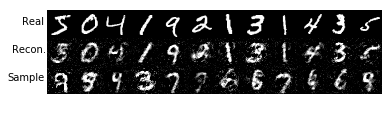

---------------------------------------------------------
Epoch: 51
439/468 [===========================>..] - ETA: 0s - Loss_D: 1.3776 - Loss_G: 0.6985 - Loss_R: 0.1408 

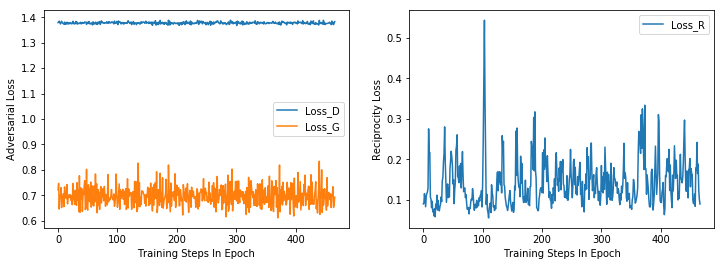

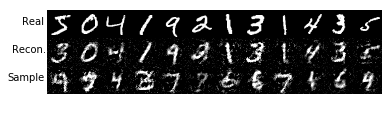

---------------------------------------------------------
Epoch: 52
444/468 [===========================>..] - ETA: 0s - Loss_D: 1.3778 - Loss_G: 0.6998 - Loss_R: 0.1550 

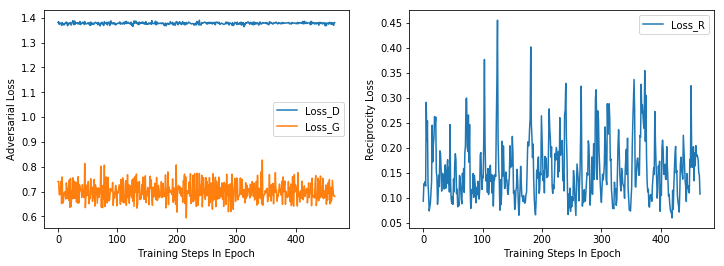

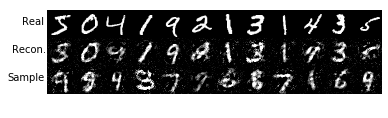

---------------------------------------------------------
Epoch: 53
441/468 [===========================>..] - ETA: 0s - Loss_D: 1.3779 - Loss_G: 0.7008 - Loss_R: 0.1614 

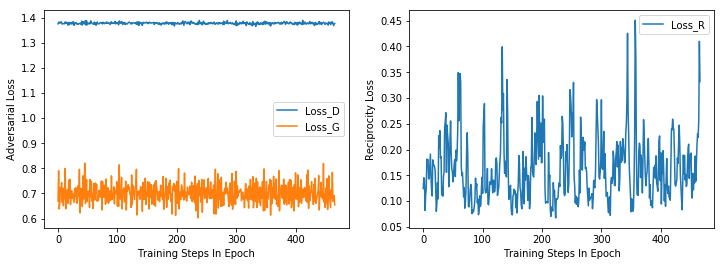

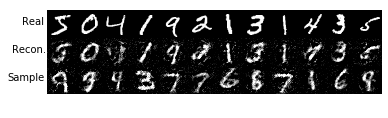

---------------------------------------------------------
Epoch: 54
440/468 [===========================>..] - ETA: 0s - Loss_D: 1.3777 - Loss_G: 0.7004 - Loss_R: 0.1706 

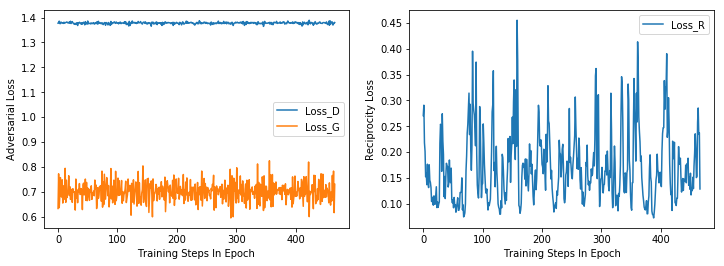

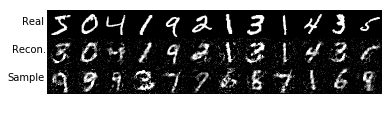

---------------------------------------------------------
Epoch: 55
436/468 [==========================>...] - ETA: 0s - Loss_D: 1.3775 - Loss_G: 0.6997 - Loss_R: 0.1869

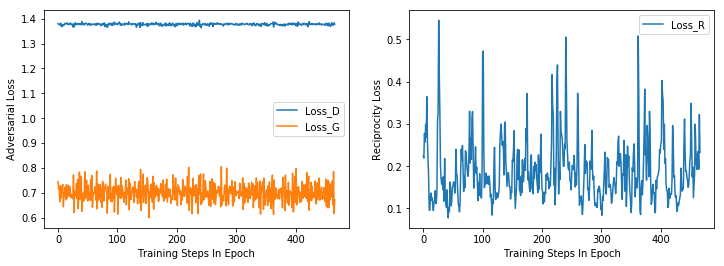

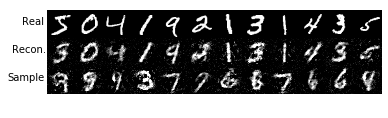

---------------------------------------------------------
Epoch: 56
441/468 [===========================>..] - ETA: 0s - Loss_D: 1.3778 - Loss_G: 0.6988 - Loss_R: 0.2088 

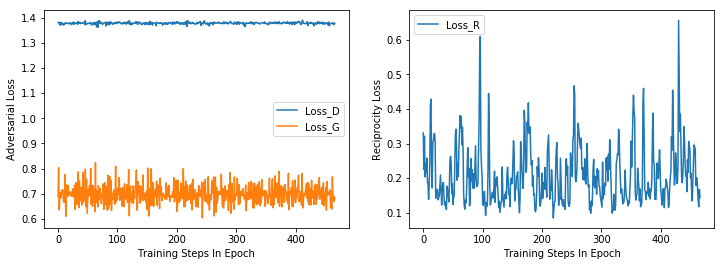

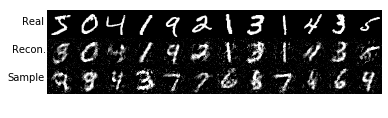

---------------------------------------------------------
Epoch: 57
441/468 [===========================>..] - ETA: 0s - Loss_D: 1.3785 - Loss_G: 0.6993 - Loss_R: 0.2226 

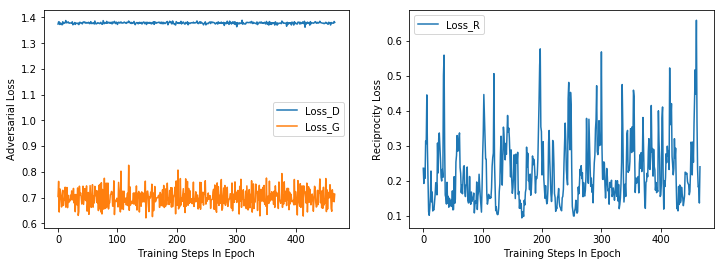

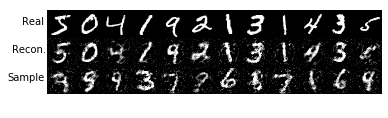

---------------------------------------------------------
Epoch: 58
441/468 [===========================>..] - ETA: 0s - Loss_D: 1.3783 - Loss_G: 0.7006 - Loss_R: 0.2453 

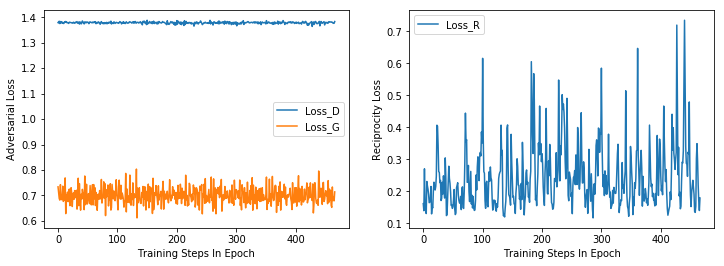

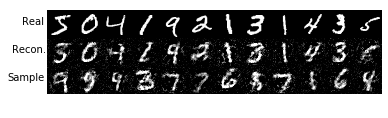

---------------------------------------------------------
Epoch: 59
442/468 [===========================>..] - ETA: 0s - Loss_D: 1.3785 - Loss_G: 0.7039 - Loss_R: 0.2817 

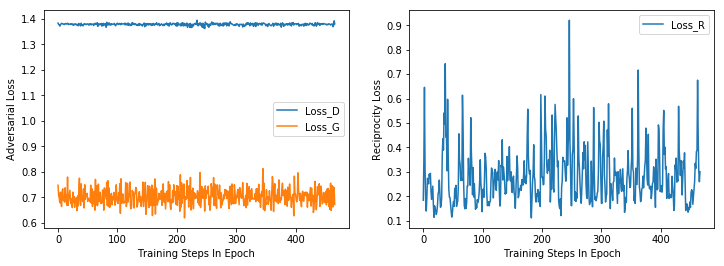

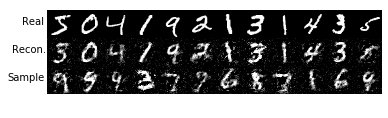

---------------------------------------------------------
Epoch: 60
441/468 [===========================>..] - ETA: 0s - Loss_D: 1.3786 - Loss_G: 0.7055 - Loss_R: 0.3110 

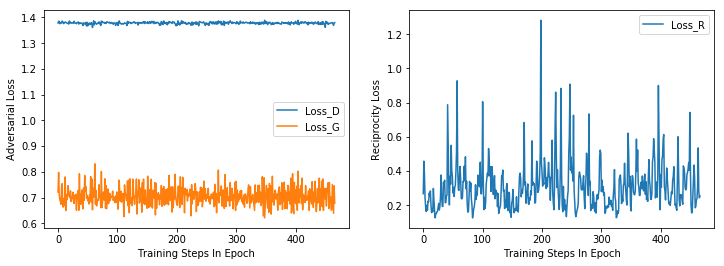

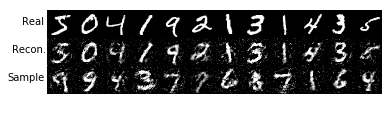

---------------------------------------------------------
Epoch: 61
442/468 [===========================>..] - ETA: 0s - Loss_D: 1.3786 - Loss_G: 0.7043 - Loss_R: 0.3071 

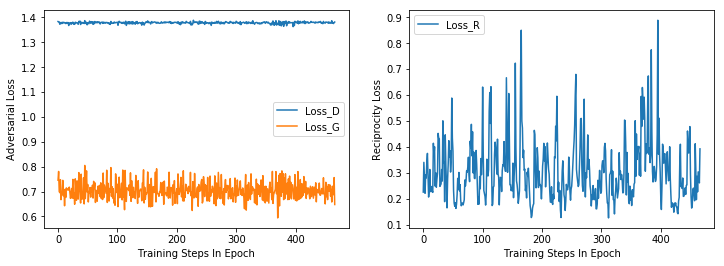

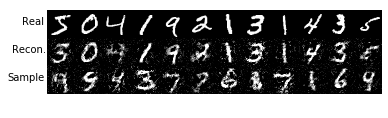

---------------------------------------------------------
Epoch: 62
444/468 [===========================>..] - ETA: 0s - Loss_D: 1.3788 - Loss_G: 0.7023 - Loss_R: 0.3161 

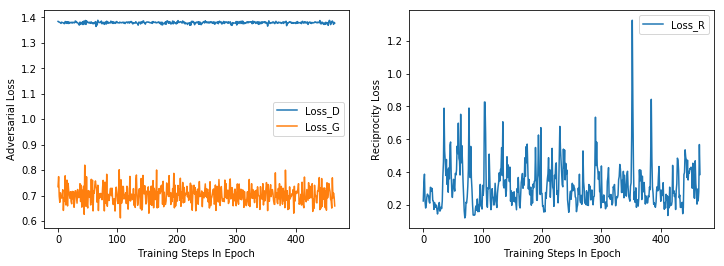

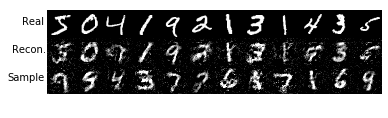

---------------------------------------------------------
Epoch: 63
436/468 [==========================>...] - ETA: 0s - Loss_D: 1.3788 - Loss_G: 0.7010 - Loss_R: 0.3288 

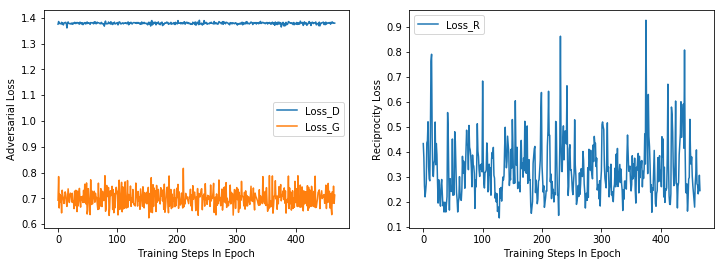

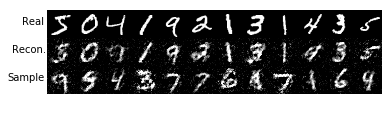

---------------------------------------------------------
Epoch: 64
431/468 [==========================>...] - ETA: 0s - Loss_D: 1.3777 - Loss_G: 0.7015 - Loss_R: 0.3615

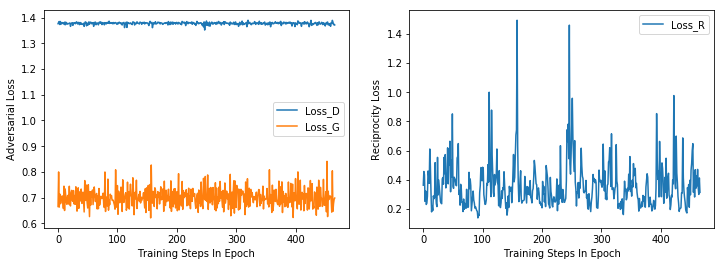

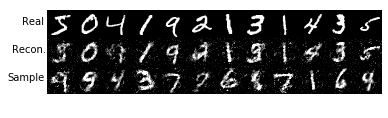

---------------------------------------------------------
Epoch: 65
440/468 [===========================>..] - ETA: 0s - Loss_D: 1.3783 - Loss_G: 0.7019 - Loss_R: 0.3770 

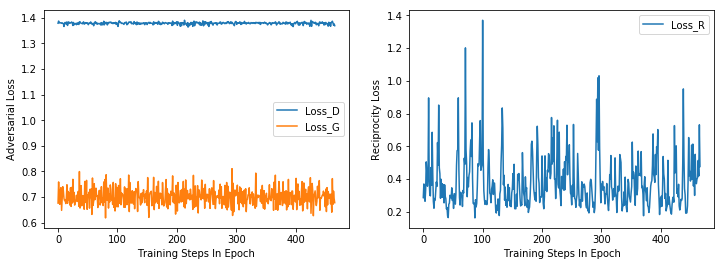

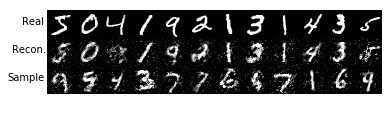

---------------------------------------------------------
Epoch: 66
441/468 [===========================>..] - ETA: 0s - Loss_D: 1.3786 - Loss_G: 0.7007 - Loss_R: 0.3801 

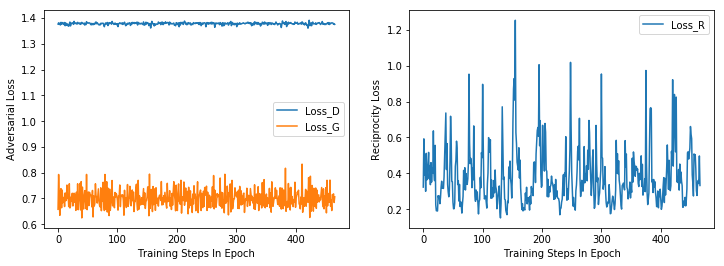

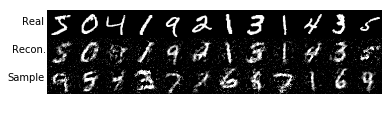

---------------------------------------------------------
Epoch: 67
442/468 [===========================>..] - ETA: 0s - Loss_D: 1.3789 - Loss_G: 0.7002 - Loss_R: 0.3921 

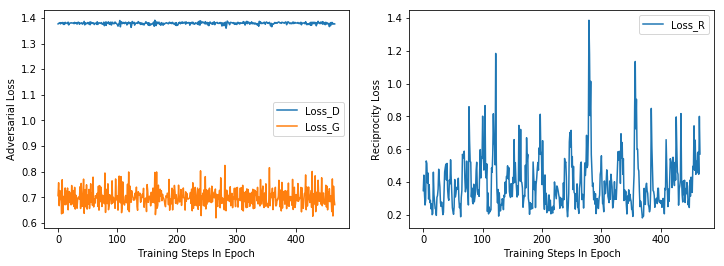

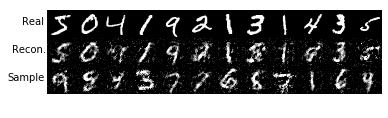

---------------------------------------------------------
Epoch: 68
441/468 [===========================>..] - ETA: 0s - Loss_D: 1.3797 - Loss_G: 0.7018 - Loss_R: 0.4203 

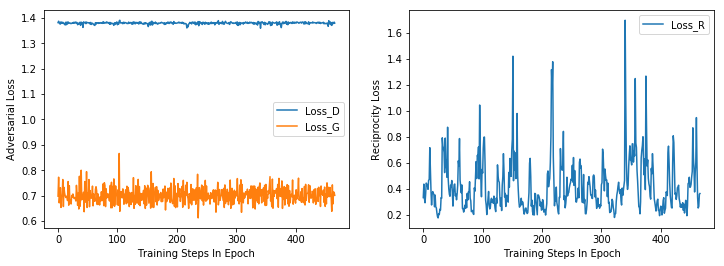

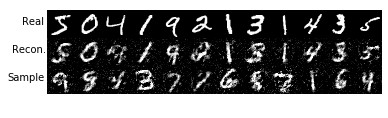

---------------------------------------------------------
Epoch: 69
441/468 [===========================>..] - ETA: 0s - Loss_D: 1.3799 - Loss_G: 0.7032 - Loss_R: 0.4419 

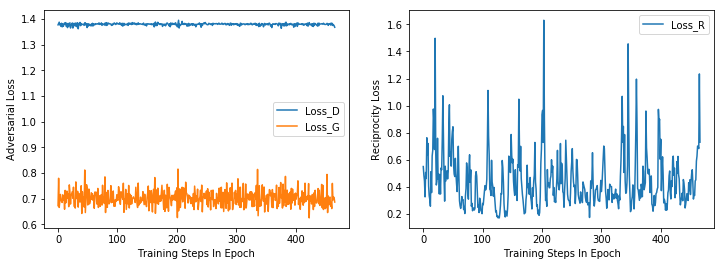

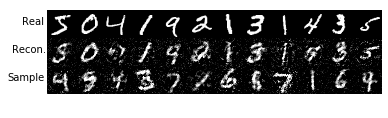

---------------------------------------------------------
Epoch: 70
438/468 [===========================>..] - ETA: 0s - Loss_D: 1.3802 - Loss_G: 0.7026 - Loss_R: 0.4599 

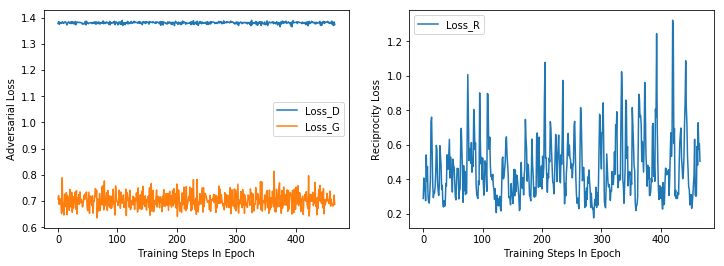

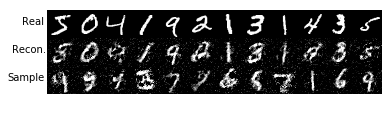

---------------------------------------------------------
Epoch: 71
439/468 [===========================>..] - ETA: 0s - Loss_D: 1.3804 - Loss_G: 0.7033 - Loss_R: 0.4734 

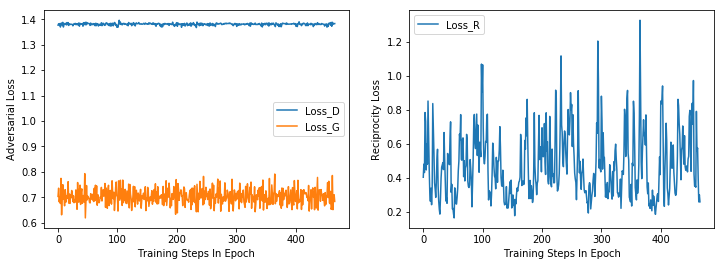

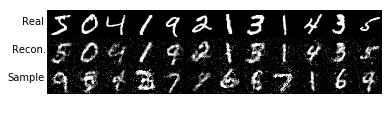

---------------------------------------------------------
Epoch: 72
442/468 [===========================>..] - ETA: 0s - Loss_D: 1.3801 - Loss_G: 0.7048 - Loss_R: 0.5191 

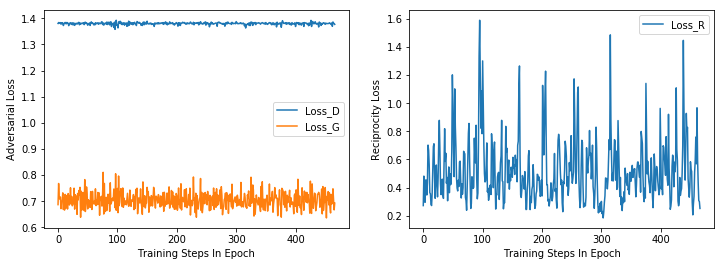

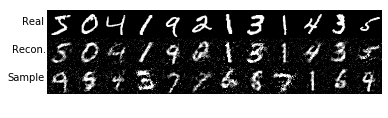

---------------------------------------------------------
Epoch: 73
442/468 [===========================>..] - ETA: 0s - Loss_D: 1.3800 - Loss_G: 0.7061 - Loss_R: 0.5508 

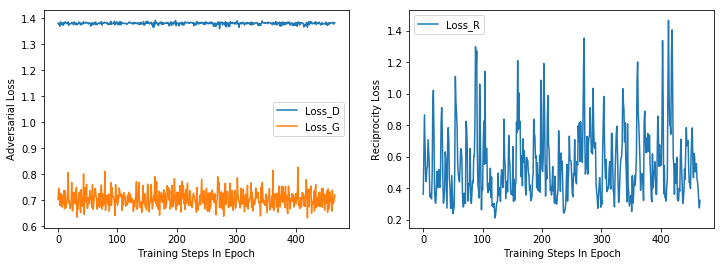

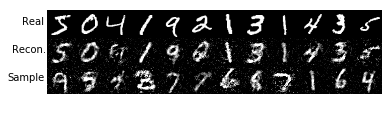

---------------------------------------------------------
Epoch: 74
441/468 [===========================>..] - ETA: 0s - Loss_D: 1.3795 - Loss_G: 0.7055 - Loss_R: 0.6239 

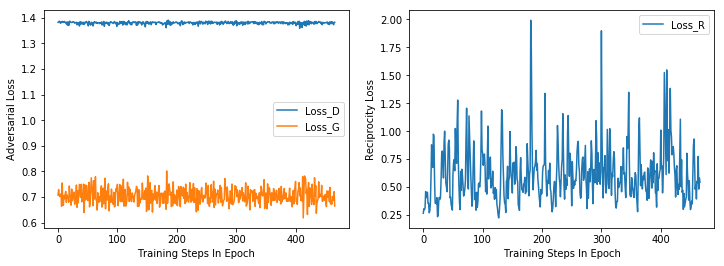

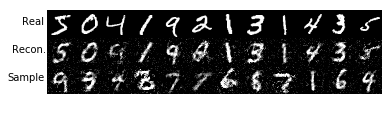

---------------------------------------------------------
Epoch: 75
443/468 [===========================>..] - ETA: 0s - Loss_D: 1.3799 - Loss_G: 0.7040 - Loss_R: 0.6151 

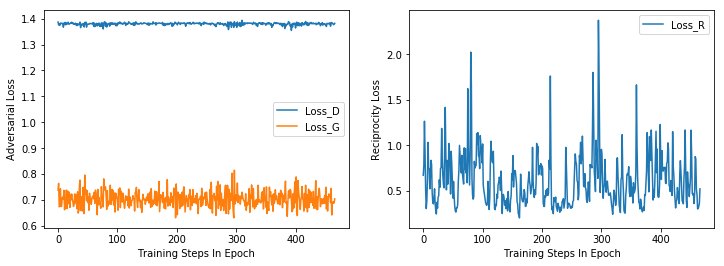

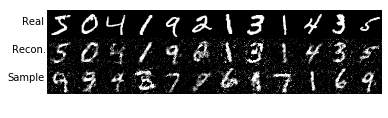

---------------------------------------------------------
Epoch: 76
446/468 [===========================>..] - ETA: 0s - Loss_D: 1.3796 - Loss_G: 0.7042 - Loss_R: 0.6603 

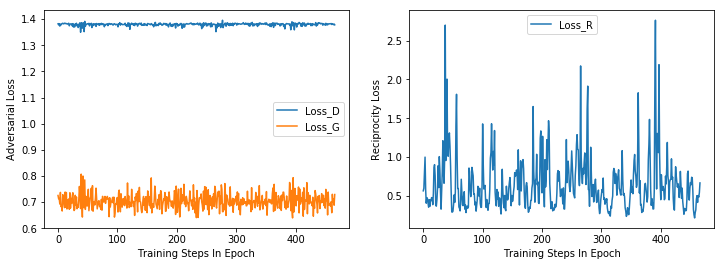

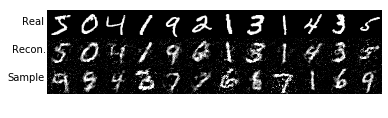

---------------------------------------------------------
Epoch: 77
445/468 [===========================>..] - ETA: 0s - Loss_D: 1.3795 - Loss_G: 0.7054 - Loss_R: 0.6583 

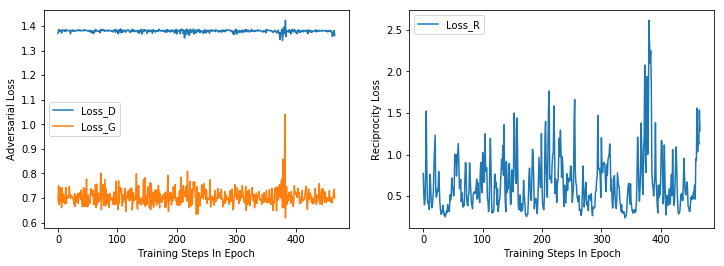

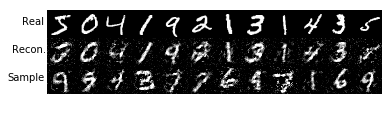

---------------------------------------------------------
Epoch: 78
440/468 [===========================>..] - ETA: 0s - Loss_D: 1.3795 - Loss_G: 0.7053 - Loss_R: 0.6643 

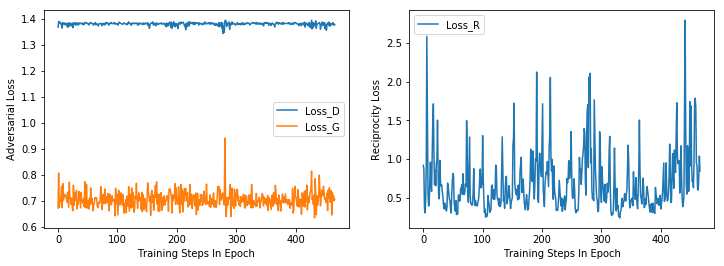

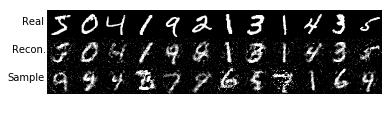

---------------------------------------------------------
Epoch: 79
446/468 [===========================>..] - ETA: 0s - Loss_D: 1.3791 - Loss_G: 0.7060 - Loss_R: 0.6558 

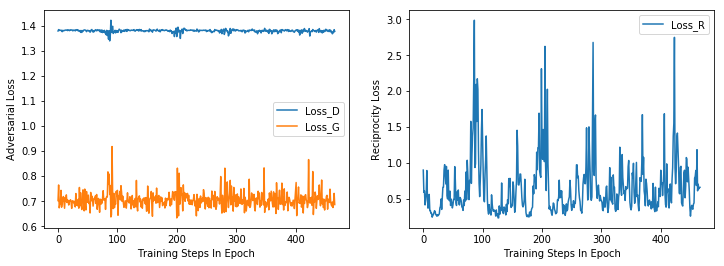

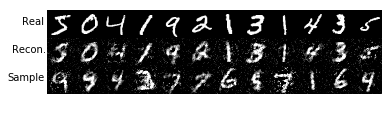

---------------------------------------------------------
Epoch: 80
442/468 [===========================>..] - ETA: 0s - Loss_D: 1.3789 - Loss_G: 0.7079 - Loss_R: 0.7263 

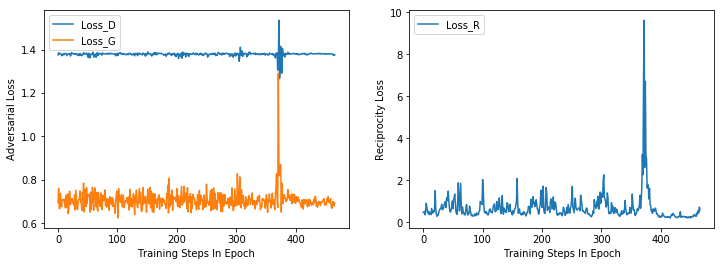

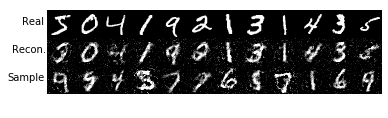

---------------------------------------------------------
Epoch: 81
442/468 [===========================>..] - ETA: 0s - Loss_D: 1.3795 - Loss_G: 0.7032 - Loss_R: 0.6840 

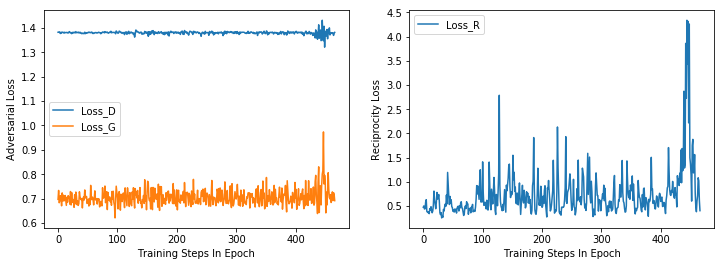

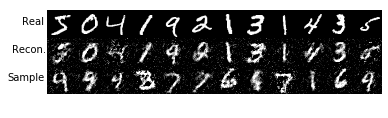

---------------------------------------------------------
Epoch: 82
443/468 [===========================>..] - ETA: 0s - Loss_D: 1.3795 - Loss_G: 0.7029 - Loss_R: 0.6454 

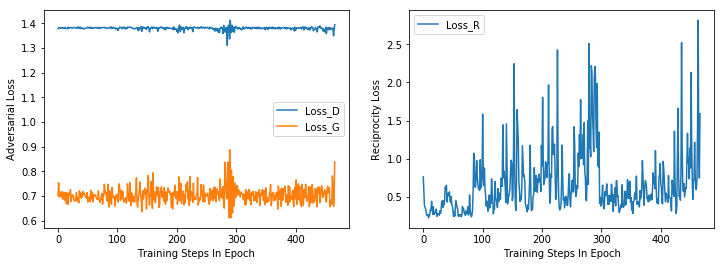

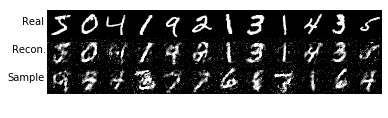

---------------------------------------------------------
Epoch: 83
439/468 [===========================>..] - ETA: 0s - Loss_D: 1.3793 - Loss_G: 0.7071 - Loss_R: 0.7936 

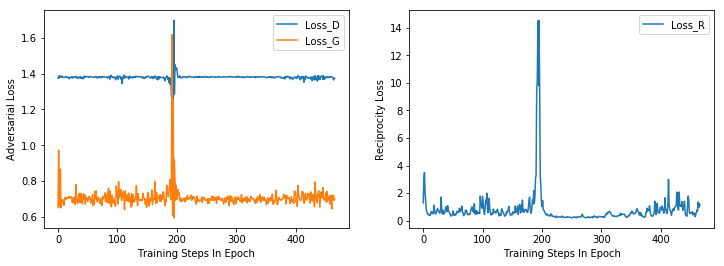

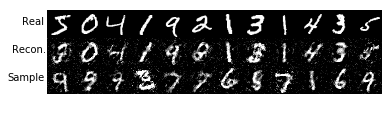

---------------------------------------------------------
Epoch: 84
439/468 [===========================>..] - ETA: 0s - Loss_D: 1.3797 - Loss_G: 0.7050 - Loss_R: 0.8125 

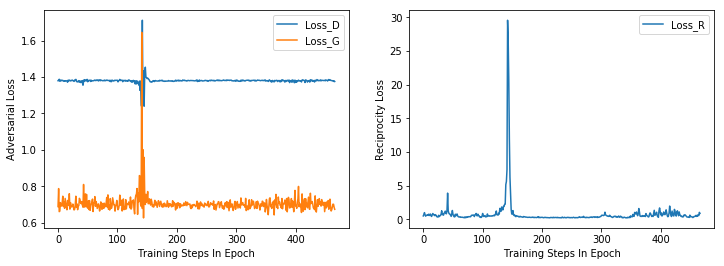

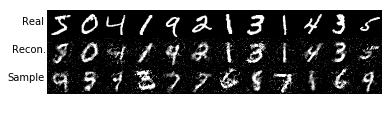

---------------------------------------------------------
Epoch: 85
439/468 [===========================>..] - ETA: 0s - Loss_D: 1.3806 - Loss_G: 0.7057 - Loss_R: 0.9288 

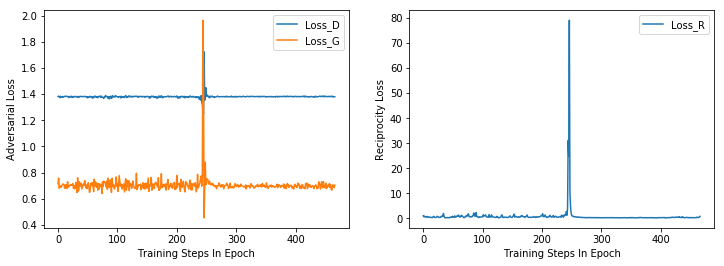

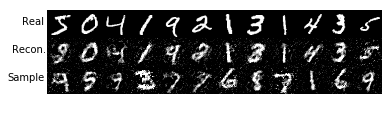

---------------------------------------------------------
Epoch: 86
442/468 [===========================>..] - ETA: 0s - Loss_D: 1.3795 - Loss_G: 0.7047 - Loss_R: 0.7991 

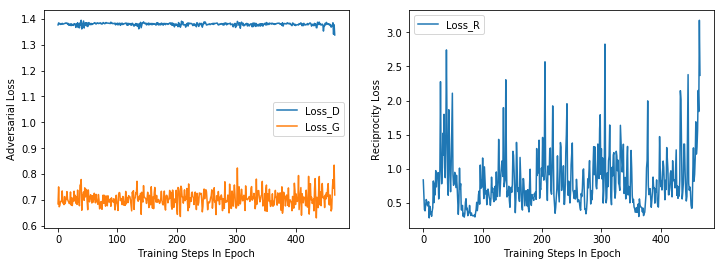

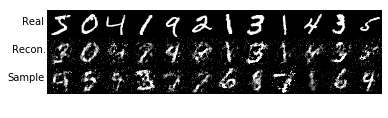

---------------------------------------------------------
Epoch: 87
442/468 [===========================>..] - ETA: 0s - Loss_D: 1.3785 - Loss_G: 0.7124 - Loss_R: 0.8798 

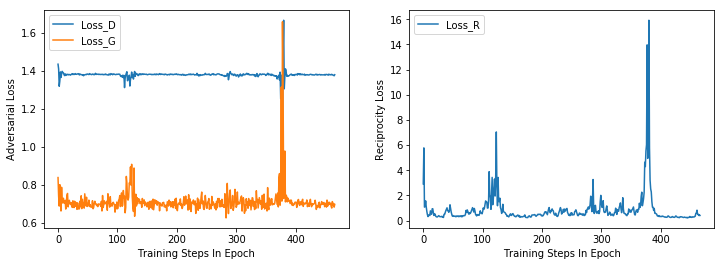

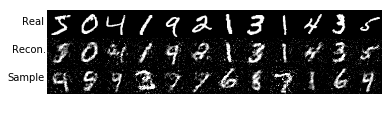

---------------------------------------------------------
Epoch: 88
439/468 [===========================>..] - ETA: 0s - Loss_D: 1.3768 - Loss_G: 0.7077 - Loss_R: 0.7539 

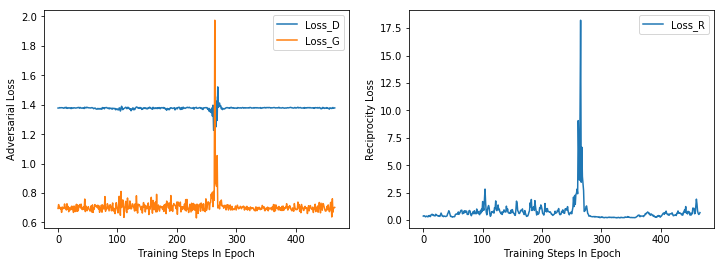

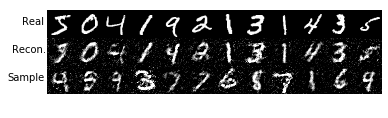

---------------------------------------------------------
Epoch: 89
443/468 [===========================>..] - ETA: 0s - Loss_D: 1.3777 - Loss_G: 0.7065 - Loss_R: 0.8634 

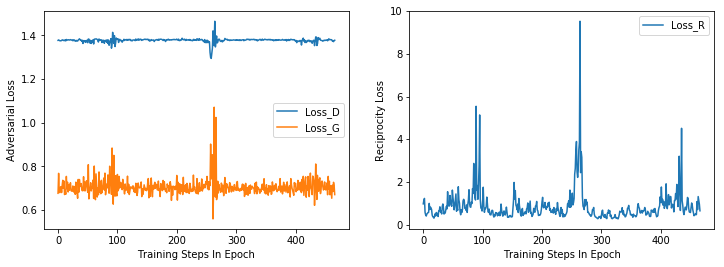

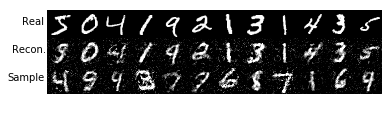

---------------------------------------------------------
Epoch: 90
441/468 [===========================>..] - ETA: 0s - Loss_D: 1.3782 - Loss_G: 0.7057 - Loss_R: 0.8426 

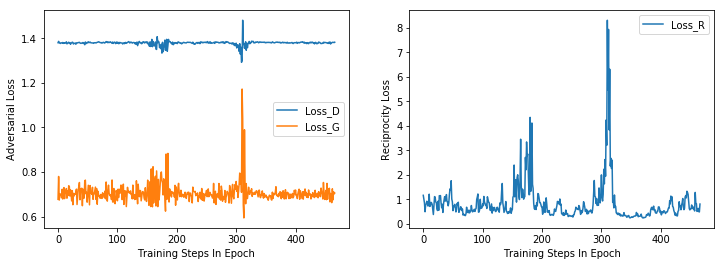

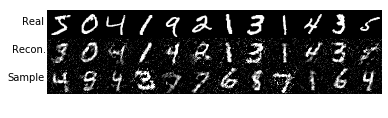

---------------------------------------------------------
Epoch: 91
439/468 [===========================>..] - ETA: 0s - Loss_D: 1.3786 - Loss_G: 0.7055 - Loss_R: 0.9031 

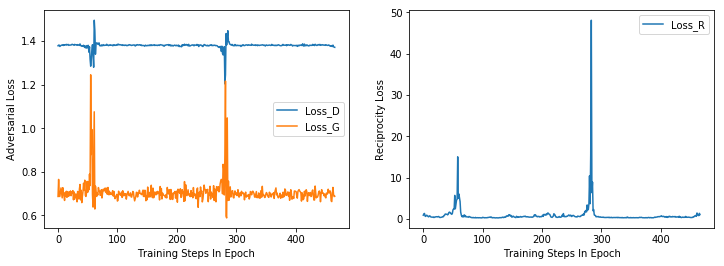

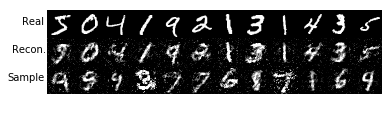

---------------------------------------------------------
Epoch: 92
444/468 [===========================>..] - ETA: 0s - Loss_D: 1.3793 - Loss_G: 0.7050 - Loss_R: 0.7862 

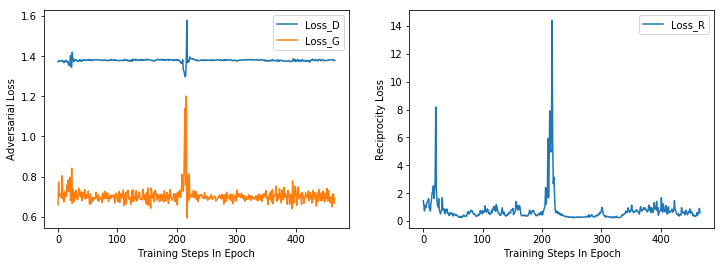

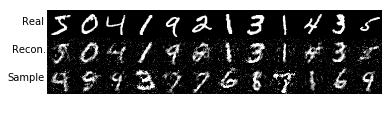

---------------------------------------------------------
Epoch: 93
441/468 [===========================>..] - ETA: 0s - Loss_D: 1.3798 - Loss_G: 0.7059 - Loss_R: 0.7669 

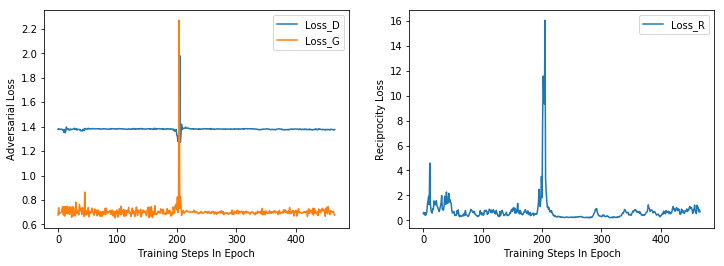

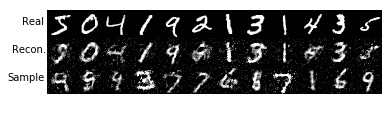

---------------------------------------------------------
Epoch: 94
440/468 [===========================>..] - ETA: 0s - Loss_D: 1.3789 - Loss_G: 0.7066 - Loss_R: 0.7630 

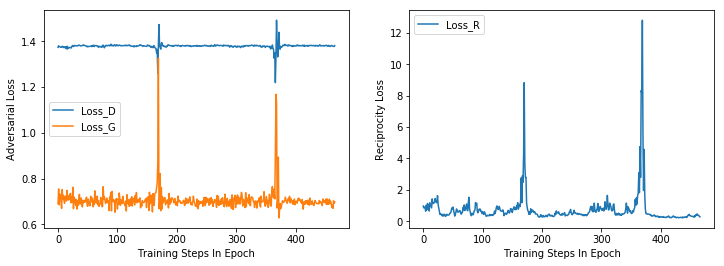

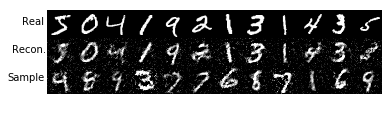

---------------------------------------------------------
Epoch: 95
442/468 [===========================>..] - ETA: 0s - Loss_D: 1.3794 - Loss_G: 0.7026 - Loss_R: 0.6656 

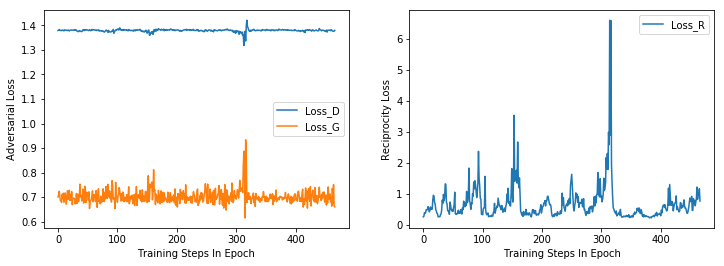

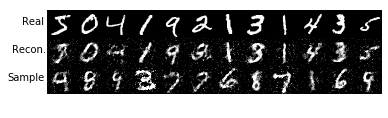

---------------------------------------------------------
Epoch: 96
447/468 [===========================>..] - ETA: 0s - Loss_D: 1.3787 - Loss_G: 0.7040 - Loss_R: 0.6813 

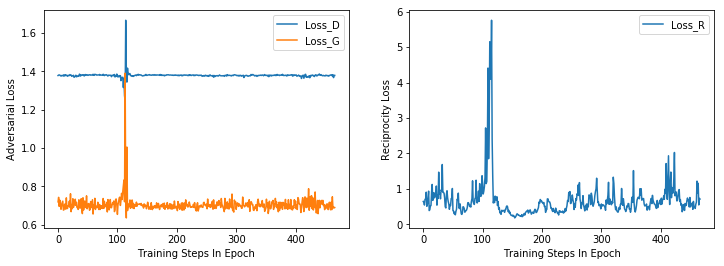

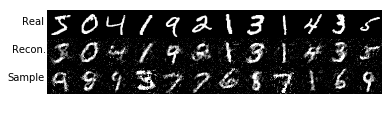

---------------------------------------------------------
Epoch: 97
439/468 [===========================>..] - ETA: 0s - Loss_D: 1.3791 - Loss_G: 0.7018 - Loss_R: 0.6786 

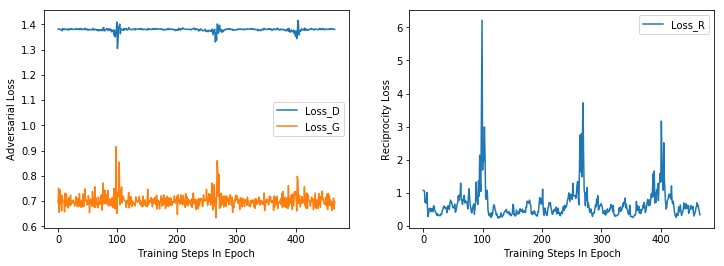

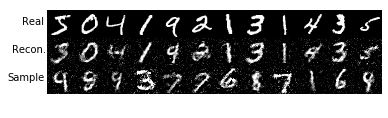

---------------------------------------------------------
Epoch: 98
467/468 [============================>.] - ETA: 0s - Loss_D: 1.3786 - Loss_G: 0.7009 - Loss_R: 0.6720  

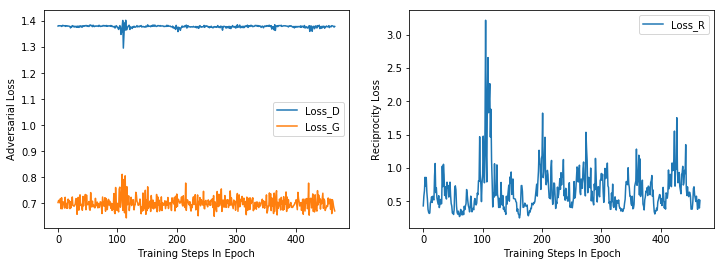

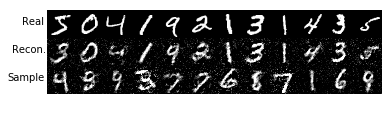

---------------------------------------------------------
Epoch: 99
445/468 [===========================>..] - ETA: 0s - Loss_D: 1.3783 - Loss_G: 0.7024 - Loss_R: 0.6570 

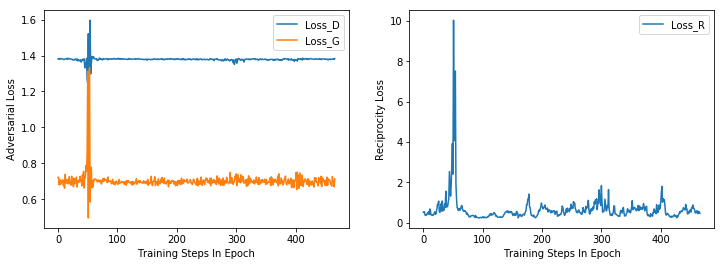

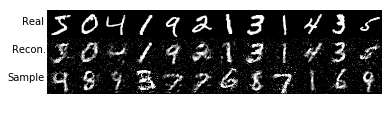

---------------------------------------------------------
Epoch: 100
444/468 [===========================>..] - ETA: 0s - Loss_D: 1.3775 - Loss_G: 0.7012 - Loss_R: 0.7810 

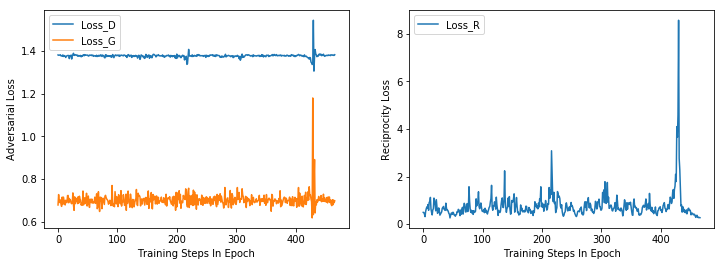

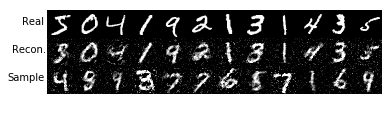

---------------------------------------------------------


In [29]:
epochs = 100
steps_per_epoch = 60000 // BATCH_SIZE

losses = {  "Loss_D" : [],
            "Loss_G" : [],
            "Loss_R" : [],
         }

for epoch in range(0, epochs):
    
    print("Epoch:", epoch+1)
    
    # Create progress bar for current epoch
    progress = Progbar(steps_per_epoch, width=30, verbose=1, interval=1)

    for i in range(steps_per_epoch):

        # -------------------------------#
        # Step I - Update Discriminator  #
        # -------------------------------#
        
        # Random mini-batch from dataset
        x_real = get_batch(i)
        # samples from prior N(0, 1)
        z = np.random.normal(0, 1, (BATCH_SIZE, Z_DIM))
        # generate fake images
        x_fake = generator.predict(z)
        
        # Compute loss and apply gradients
        loss_d, _ = sess.run([L_adv_E_D, ADAM_d], 
                        feed_dict={ discriminator_real_in: x_real,
                                    discriminator_fake_in: x_fake
                            })
        

        # ----------------------------#
        #  Step II - Update Generator #
        # ----------------------------#
        
        # samples from prior N(0, 1)
        z = np.random.normal(0, 1, (BATCH_SIZE, Z_DIM))
        # Compute loss and apply gradients
        loss_g, _ = sess.run([L_adv_F_G, ADAM_g], 
                        feed_dict={ generator_fake_in: z,
                            })
        

        
        # ------------------------------#
        #  Step III - Update Reciprocal #
        # ------------------------------#
        
        # samples from prior N(0, 1)
        z = np.random.normal(0, 1, (BATCH_SIZE, Z_DIM))
        # Get w
        w = F.predict(z)
        # Compute loss and apply gradients
        loss_r, _ = sess.run([L_recip, ADAM_r], 
                        feed_dict={ reciprocal_in: w,
                                     inference_in: x_real
                            })
        

        # Progress
        progress.update(i, values=[ ("Loss_D", loss_d),
                                    ("Loss_G", loss_g),
                                    ("Loss_R", loss_r),
                                  ])
        
        # Save losses each step
        losses["Loss_D"].append(loss_d)
        losses["Loss_G"].append(loss_g)
        losses["Loss_R"].append(loss_r)
    
    # ---------------#
    #  END OF EPOCH  #
    # ---------------#
    
    
    # LOSSES
    n = steps_per_epoch-1
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(range(n), losses["Loss_D"][-n:], label="Loss_D")
    ax[0].plot(range(n), losses["Loss_G"][-n:], label="Loss_G")
    ax[0].set_xlabel("Training Steps In Epoch")
    ax[0].set_ylabel("Adversarial Loss")
    ax[0].legend()

    ax[1].plot(range(n), losses["Loss_R"][-n:], label="Loss_R")
    ax[1].set_xlabel("Training Steps In Epoch")
    ax[1].set_ylabel("Reciprocity Loss")
    ax[1].legend()
    plt.show()
    
    # IMAGES
    
    # Get random samples
    x_sample = generator.predict(z_test)
    x_sample = x_sample.reshape(12, 28, 28)
    x_sample = [img for img in x_sample]
    x_sample = np.hstack(x_sample)

    # Get reconstructions
    x_recon = inference.predict(x_test)
    x_recon = x_recon.reshape(12, 28, 28)
    x_recon = [img for img in x_recon]
    x_recon = np.hstack(x_recon)

    # Create canvas
    canvas = np.vstack([x_reals, x_recon, x_sample])
    canvas = np.clip(canvas, 0, 1)

    # Show
    plt.imshow(canvas, cmap="gray")
    plt.text(-25, 14, s="Real")
    plt.text(-35, 14*3, s="Recon.")
    plt.text(-40, 14*5, s="Sample")
    plt.axis("off")
    
    #plt.savefig("./img_out/progress_{0:03d}.png".format(epoch), dpi=100)
    plt.show()

    # Shuffle Data
    #np.random.shuffle(indices)
    
    print("---------------------------------------------------------")

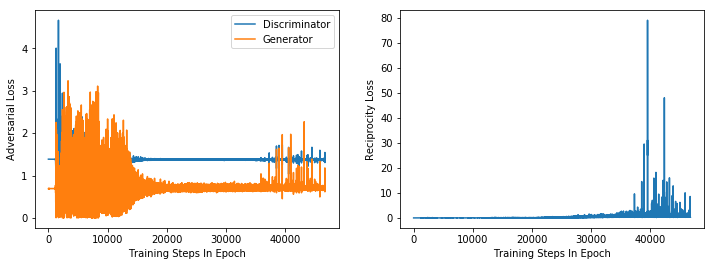

In [31]:
# LOSSES
n = len(losses["Loss_D"])
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(range(n), losses["Loss_D"][-n:], label="Discriminator")
ax[0].plot(range(n), losses["Loss_G"][-n:], label="Generator")
ax[0].set_xlabel("Training Steps In Epoch")
ax[0].set_ylabel("Adversarial Loss")
ax[0].legend()

ax[1].plot(range(n), losses["Loss_R"][-n:])
ax[1].set_xlabel("Training Steps In Epoch")
ax[1].set_ylabel("Reciprocity Loss")

plt.savefig("./TF_MNIST_traing_curve_100_epochs.png", dpi=100)
plt.show()

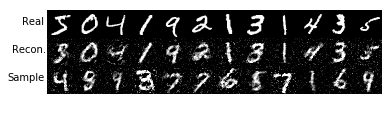

In [32]:
# Show
plt.imshow(canvas, cmap="gray")
plt.text(-25, 14, s="Real")
plt.text(-35, 14*3, s="Recon.")
plt.text(-40, 14*5, s="Sample")
plt.axis("off")

plt.savefig("./TF_MNIST_100_epochs.png", dpi=100)
plt.show()

https://github.com/podgorskiy/ALAE/blob/master/losses.py

https://github.com/smthomas-sci/IntrospectiveVariationalAutoencoder/blob/master/introvae/main_style_generator.py

https://blog.keras.io/keras-as-a-simplified-interface-to-tensorflow-tutorial.html